# Imports

In [1]:
import os, re, sys, pickle, datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA,NMF
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression,Ridge,ElasticNetCV,ElasticNet,Lars,LassoCV,RidgeCV,LarsCV,LassoLarsCV,LassoLarsIC,OrthogonalMatchingPursuitCV,OrthogonalMatchingPursuit
from sklearn.manifold import TSNE,MDS
from sklearn import metrics
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedKFold,LeaveOneOut,cross_val_score,cross_validate
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.svm import LinearSVC,SVR
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
#from sklearn import tree

#import statsmodels.api as sm
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
from joblib import Parallel,delayed



import warnings
warnings.filterwarnings("ignore")

#import loo_q2 as loo

randomstate = 42

def plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=[]):
    y_orig_min = np.min(np.hstack((y_train,y_test)))
    y_pred_min = np.min(np.hstack((y_pred_train,y_pred_test)))
    y_orig_max = np.max(np.hstack((y_train,y_test)))
    y_pred_max = np.max(np.hstack((y_pred_train,y_pred_test)))#conda
    delta_x = 0.04 * (y_orig_max-y_orig_min)
    delta_y = 0.04 * (y_pred_max-y_pred_min)
           
    yy_fit = np.polyfit(y_train,y_pred_train,deg=1)
    yy_fit_line = yy_fit[1]+yy_fit[0]*y_train
    
    plt.figure(figsize=(5,5))
    plt.plot(np.linspace(y_orig_min-delta_x,y_orig_max+delta_x), np.linspace(y_orig_min-delta_x,y_orig_max+delta_x),color="grey")
    plt.xlim([y_orig_min-delta_x,y_orig_max+delta_x])
    plt.ylim([y_pred_min-delta_y,y_pred_max+delta_y])
    if len(loo_pred) != 0:
        #plt.scatter(y_train,loo_train,label="LOO",color="black",marker="s",facecolor='none')
        plt.scatter(y_train,y_pred_train,label="training",color="black",marker="s") # ,alpha=0.6
    plt.scatter(y_test,y_pred_test,label="test",color="red",marker="s")     #,alpha=0.25
    plt.plot(y_train,yy_fit_line,color="black") #,alpha=0.2
    if leg:
        plt.legend(loc='lower right')
    plt.xlabel(label+" measured",fontsize=20)
    plt.ylabel(label+" predicted",fontsize=20)
    
#     plt.xticks([])
#     plt.yticks([])
    
    if not sav:
        plt.show()  
    else:
        plt.savefig(sav)
        
def r2_val(y_test,y_pred_test,y_train):
    """Calculates the external R2 pred as described:
    https://pdfs.semanticscholar.org/4eb2/5ff5a87f2fd6789c5b9954eddddfd1c59dab.pdf"""
    y_resid = y_pred_test - y_test
    SS_resid = np.sum(y_resid**2)
    y_var = y_test - np.mean(y_train)
    SS_total = np.sum(y_var**2)
    r2_validation = 1-SS_resid/SS_total
    return(r2_validation)

def repeated_k_fold(X_train,y_train,reg = LinearRegression(), k=3, n=100):
    """Reapeated k-fold cross-validation. 
    For each of n repeats, the (training)data is split into k folds. 
    For each fold, this part of the data is predicted using the rest. 
    Once this is done for all k folds, the coefficient of determination (R^2) of the predictions of all folds combined (= the complete data set) is evaluated
    This is repeated n times and all n R^2 are returned for averaging/further analysis
    """
    
    rkf = RepeatedKFold(n_splits=k, n_repeats=n)
    r2_scores = []
    y_validations,y_predictions = np.zeros((np.shape(X_train)[0],n)),np.zeros((np.shape(X_train)[0],n))
    foldcount = 0
    for i,foldsplit in enumerate(rkf.split(X_train)):
        fold, rep = i%k, int(i/k) # Which of k folds. Which of n repeats
        model = reg.fit(X_train[foldsplit[0]],y_train[foldsplit[0]]) # foldsplit[0]: k-1 training folds
        y_validations[foldcount:foldcount+len(foldsplit[1]),rep] = y_train[foldsplit[1]] # foldsplit[1]: validation fold
        y_predictions[foldcount:foldcount+len(foldsplit[1]),rep]  = model.predict(X_train[foldsplit[1]])
        foldcount += len(foldsplit[1])
        if fold+1==k:
            foldcount = 0
    r2_scores = np.asarray([metrics.r2_score(y_validations[:,rep],y_predictions[:,rep]) for rep in range(n)])
    return(r2_scores)

# keepmodels = []

# Reading data

## Single File

In [4]:
# all data in a single file
excel_file = "190415_P_ligands_base_overview"
excel_sheet = "Tabelle2"
num_par = 141
par_start_col = 3 # 0-indexed
num_samples = 23
response_col = 2 # 0-indexed
y_label_col = 0 # 0-indexed

apply_mask = True # remove samples with empty response
verbose = True
xlabelrow = True

inp = pd.read_excel(excel_file+".xlsx",excel_sheet,header=0,index_col=y_label_col,nrows=num_samples+int(xlabelrow),
                    usecols=max(y_label_col,response_col,num_par+par_start_col)-1)
if xlabelrow:
    X_names = list(inp.iloc[0,par_start_col-1:num_par+par_start_col-1])
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    resp_label = list(inp.columns)[response_col-1]
    inp.drop(index=inp.index[0],inplace=True)
else:
    X_labels = list(inp.columns)[par_start_col-1:num_par+par_start_col-1]
    X_names = X_labels
    resp_label = list(inp.columns)[response_col-1]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))
y = np.asarray(inp[resp_label],dtype=np.float)
X = np.asarray(inp[X_labels],dtype=np.float)
y_labels = np.asarray(list(inp.index),dtype=str)
y_labels_comp= y_labels

if apply_mask:
    mask = y.nonzero()[0]
    mask = ~np.isnan(y)
    print("n_samples before removing empty cells: {}".format(len(y)))
    print("Removing {} samples.".format(len(y)-sum(mask)))
    X = X[np.array(mask)]
    y = y[np.array(mask)]
    y_labels = y_labels[np.array(mask)]
X_all = X
if verbose:
    print("Shape X: {}".format(X.shape))
    print("Shape y: {}".format(y.shape)) 
    print("Shape labels: {}".format(y_labels.shape)) 
    print("First X cell: {}".format(X[0,0]))
    print("Last X cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label: {}".format(y_labels[-1]))
    #print(inp.head())

ValueError: Passing an integer for `usecols` is no longer supported.  Please pass in a list of int from 0 to `usecols` inclusive instead.

## Separate Files

In [ ]:
## separate files for exp data and comp data, even if in same excel but on different tabs

comp_file = "modeling_example_copy"
comp_sheet = "comp"
num_par = 182 #number of parameters
par_start_col = 1 # 0-indexed
comp_num_samples = 1358 #number of phosphines in the comp file
y_label_col_comp = 0 # 0-indexed

exp_file = "modeling_example_copy"
exp_sheet = "exp"
exp_num_samples = 1338 
response_col = 33 # 0-indexed
y_label_col_exp = 1 # 0-indexed

compinp = pd.read_excel(comp_file+".xlsx",comp_sheet,header=0,index_col=y_label_col_comp,
                        nrows=comp_num_samples+1,usecols=num_par+par_start_col-1)
compinp.index = compinp.index.map(str)
expinp = pd.read_excel(exp_file+".xlsx",exp_sheet,header=4,index_col=y_label_col_exp,
                       nrows=exp_num_samples,usecols=response_col)
expinp.index = [i.zfill(4) for i in expinp.index.map(str)]

xlabelrow = True
verbose = True

X_names = list(compinp.iloc[0,par_start_col-1:num_par+par_start_col-1])
X_labels = list(compinp.columns)[par_start_col-1:num_par+par_start_col-1]
compinp.drop(index=compinp.index[0],inplace=True)
X_all = np.asarray(compinp[X_labels],dtype=np.float)
y_labels_comp = np.asarray(list(compinp.index),dtype=str)
compnan = np.isnan(X_all).any(axis=1)
y_labels_comp,X_all = y_labels_comp[~compnan],X_all[~compnan]

X_labelname = [" ".join(i) for i in zip(X_labels,X_names)] 
X_labelname_dict = dict(zip(X_labels,X_names))

resp_label = list(expinp.columns)[response_col-1]
y = np.asarray(expinp.iloc[:,response_col-1],dtype=np.float)
y_labels_exp = np.asarray(list(expinp.index),dtype=str)

mask_y = y.nonzero()[0]
mask_y = ~np.isnan(y)
mask_X = np.array([True if i in y_labels_comp else False for i in y_labels_exp])
mask = mask_y&mask_X
print("n_samples before removing empty cells: {}".format(len(y)))
print("Removing {} samples.".format(len(y)-sum(mask)))
y = y[np.array(mask)]
y_labels = y_labels_exp[np.array(mask)]

X = np.asarray(compinp.loc[y_labels],dtype=np.float)

if verbose:
    print("Shape X (all): {}".format(X_all.shape))
    print("Shape X (exp): {}".format(X.shape))
    print("Shape y (exp): {}".format(y.shape)) 
    print("Shape labels (exp): {}".format(y_labels.shape)) 
    print("First X (exp) cell: {}".format(X[0,0]))
    print("Last X (exp) cell:  {}".format(X[-1,-1]))
    print("First y: {}".format(y[0]))
    print("Last y:  {}".format(y[-1]))
    print("Last label exp: {}".format(y_labels[-1]))
    print("Last label comp: {}".format(y_labels_comp[-3:]))
    #print(inp.head())

n_samples before removing empty cells: 1338
Removing 1276 samples.
Shape X (all): (1358, 182)
Shape X (exp): (62, 182)
Shape y (exp): (62,)
Shape labels (exp): (62,)
First X (exp) cell: -0.0712447
Last X (exp) cell:  0.6329624644776612
First y: 1.0743358045184732
Last y:  100.0
Last label exp: 0566
Last label comp: ['1524' '1525' '1526']


# Basic visualization

 ## Histograms and univariate correlations

x1 Vmin_LP(P).Boltz


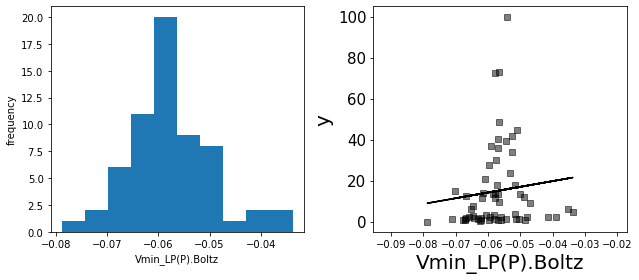

R^2 = 0.01; p-value = 0.39

-------------------------------------------------------------------------------

x2 Vmin_R.Boltz


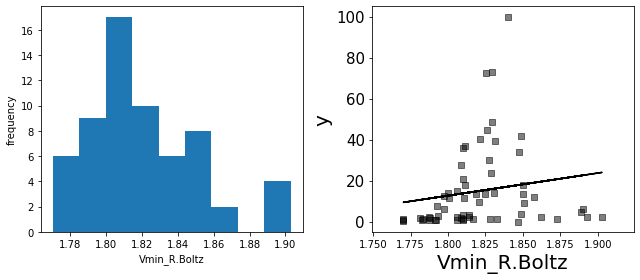

R^2 = 0.03; p-value = 0.20

-------------------------------------------------------------------------------

x3 efg_ampl(P).Boltz


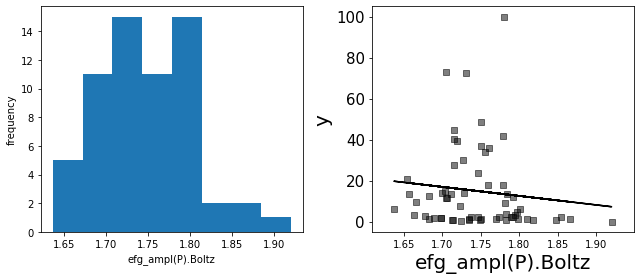

R^2 = 0.01; p-value = 0.36

-------------------------------------------------------------------------------

x4 efg_xx(P).Boltz


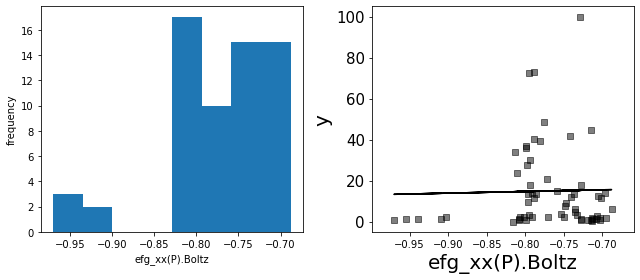

R^2 = 0.00; p-value = 0.85

-------------------------------------------------------------------------------

x5 efg_yy(P).Boltz


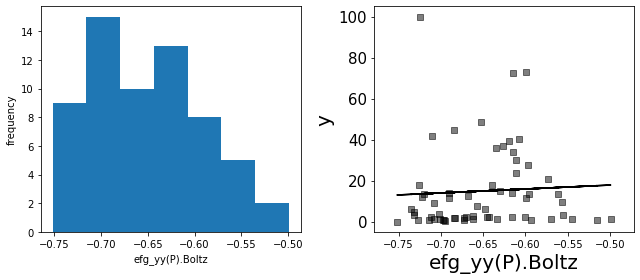

R^2 = 0.00; p-value = 0.67

-------------------------------------------------------------------------------

x6 efg_zz(P).Boltz


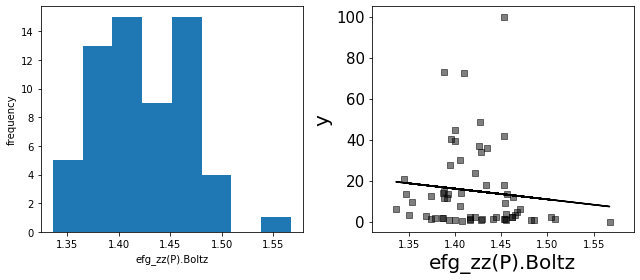

R^2 = 0.01; p-value = 0.39

-------------------------------------------------------------------------------

x7 nuesp_nuesp(P).Boltz


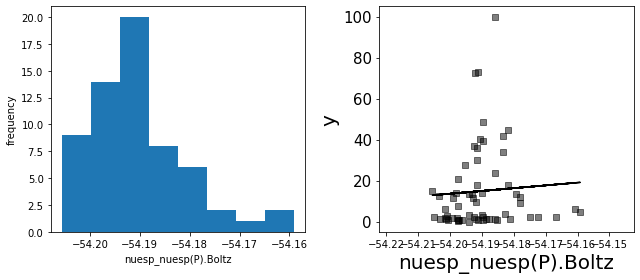

R^2 = 0.00; p-value = 0.61

-------------------------------------------------------------------------------

x8 fukui_f+(P).Boltz


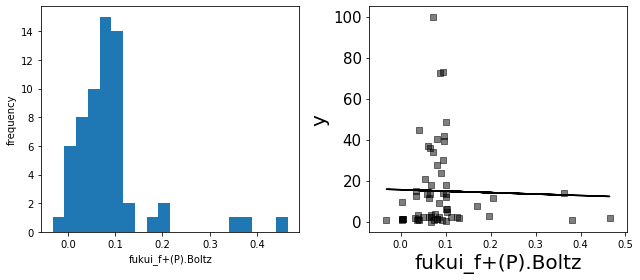

R^2 = 0.00; p-value = 0.82

-------------------------------------------------------------------------------

x9 fukui_f-(P).Boltz


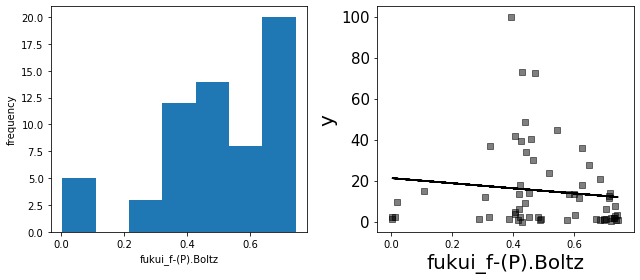

R^2 = 0.01; p-value = 0.35

-------------------------------------------------------------------------------

x10 hirsh_D(P).Boltz


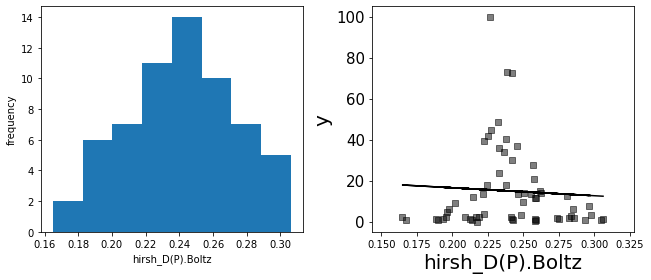

R^2 = 0.00; p-value = 0.63

-------------------------------------------------------------------------------

x11 hirsh_Q-CM5(P).Boltz


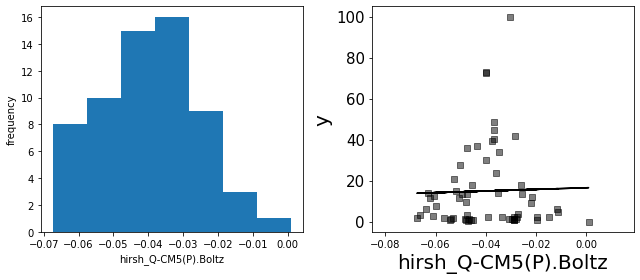

R^2 = 0.00; p-value = 0.82

-------------------------------------------------------------------------------

x12 hirsh_Q-H(P).Boltz


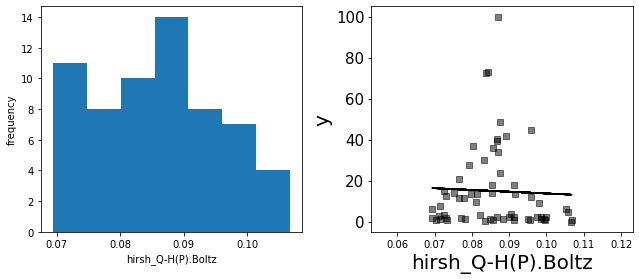

R^2 = 0.00; p-value = 0.74

-------------------------------------------------------------------------------

x13 homo_eta.Boltz


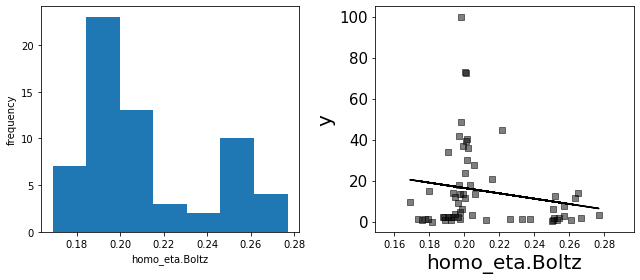

R^2 = 0.03; p-value = 0.16

-------------------------------------------------------------------------------

x14 homo_homo.Boltz


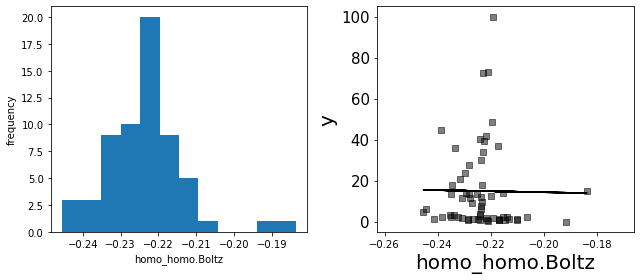

R^2 = 0.00; p-value = 0.92

-------------------------------------------------------------------------------

x15 homo_lumo.Boltz


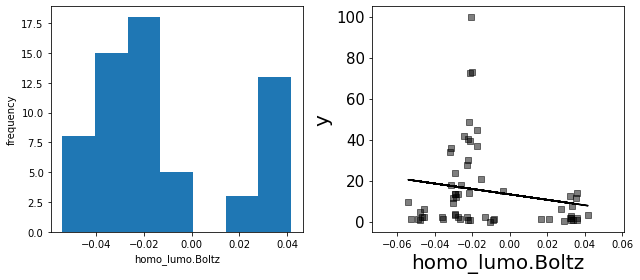

R^2 = 0.03; p-value = 0.15

-------------------------------------------------------------------------------

x16 homo_mu.Boltz


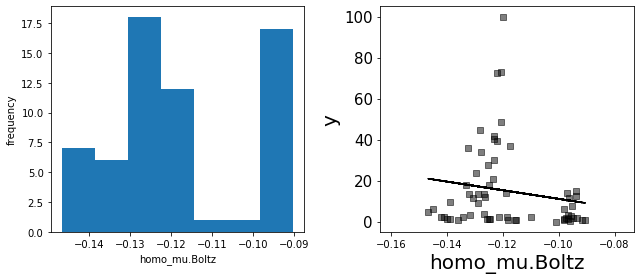

R^2 = 0.03; p-value = 0.20

-------------------------------------------------------------------------------

x17 homo_omega.Boltz


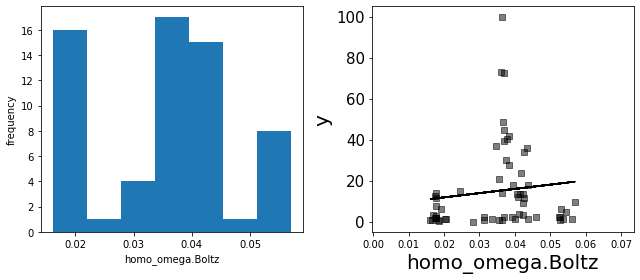

R^2 = 0.01; p-value = 0.35

-------------------------------------------------------------------------------

x18 nbo_P.Boltz


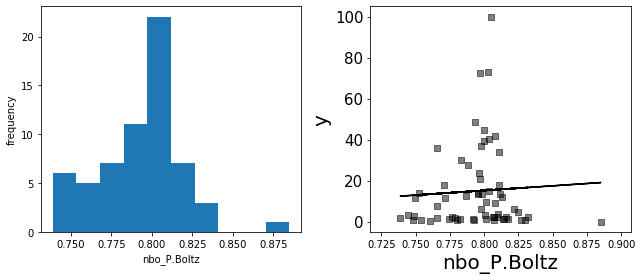

R^2 = 0.00; p-value = 0.66

-------------------------------------------------------------------------------

x19 nborbsP_BD-S(P-C)_avg_E.Boltz


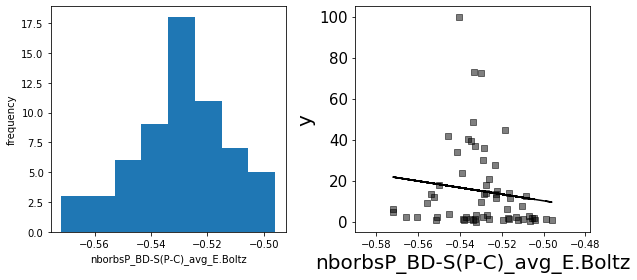

R^2 = 0.02; p-value = 0.29

-------------------------------------------------------------------------------

x20 nborbsP_BD-S(P-C)_max_E.Boltz


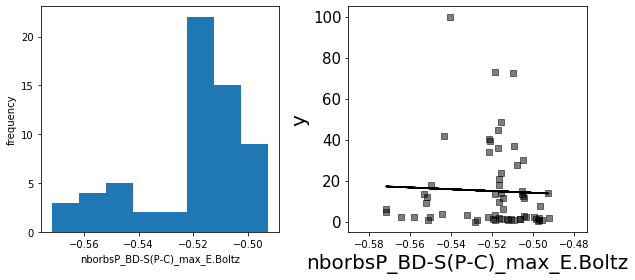

R^2 = 0.00; p-value = 0.74

-------------------------------------------------------------------------------

x21 nborbsP_BD-S(P-C)_avg_Occ.Boltz


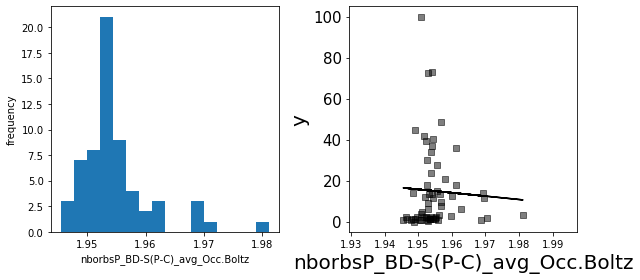

R^2 = 0.00; p-value = 0.69

-------------------------------------------------------------------------------

x22 nborbsP_BD-S(P-C)_min_Occ.Boltz


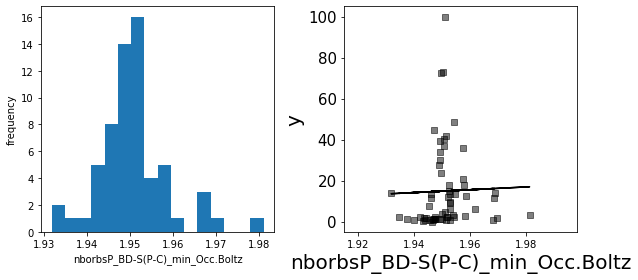

R^2 = 0.00; p-value = 0.83

-------------------------------------------------------------------------------

x23 nborbsP_BD-S*(P-C)_avg_E.Boltz


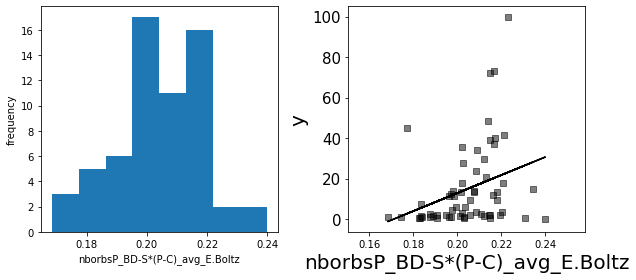

R^2 = 0.10; p-value = 0.01

-------------------------------------------------------------------------------

x24 nborbsP_BD-S*(P-C)_min_E.Boltz


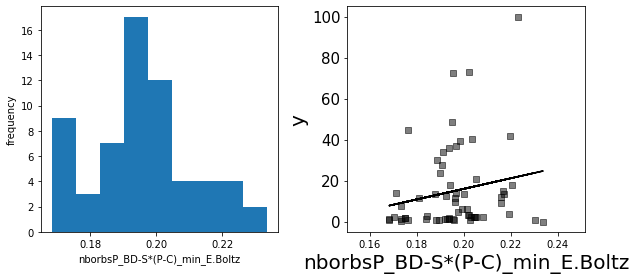

R^2 = 0.04; p-value = 0.13

-------------------------------------------------------------------------------

x25 nborbsP_BD-S*(P-C)_avg_Occ.Boltz


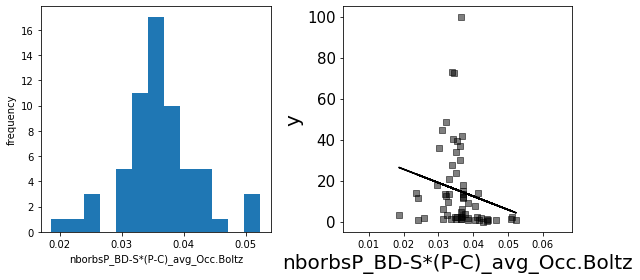

R^2 = 0.04; p-value = 0.12

-------------------------------------------------------------------------------

x26 nborbsP_BD-S*(P-C)_max_Occ.Boltz


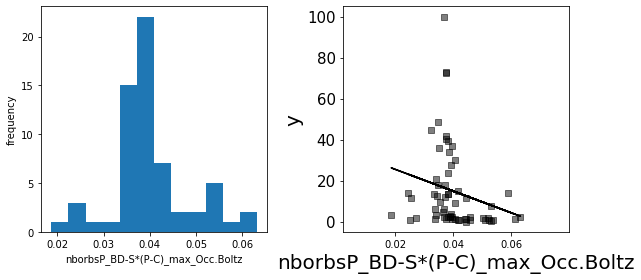

R^2 = 0.05; p-value = 0.09

-------------------------------------------------------------------------------

x27 nborbsP_percent s LP(P).Boltz


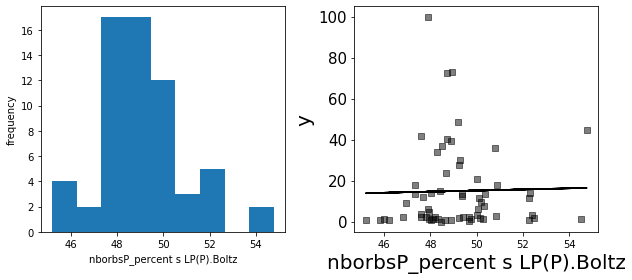

R^2 = 0.00; p-value = 0.85

-------------------------------------------------------------------------------

x28 nborbsP_LP(P)_E.Boltz


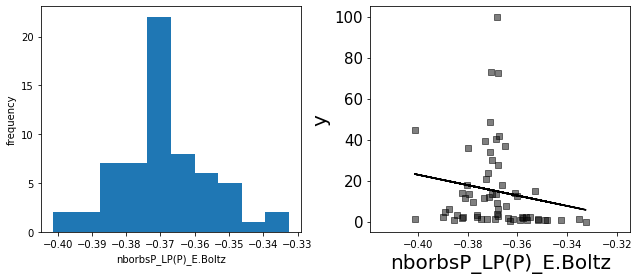

R^2 = 0.03; p-value = 0.19

-------------------------------------------------------------------------------

x29 nborbsP_LP(P)_Occ.Boltz


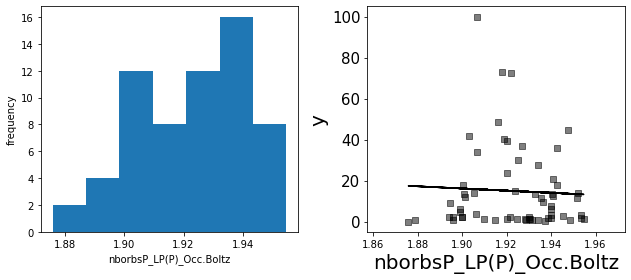

R^2 = 0.00; p-value = 0.69

-------------------------------------------------------------------------------

x30 nborbsP_delta(BD-S*-LP(P))_E.Boltz


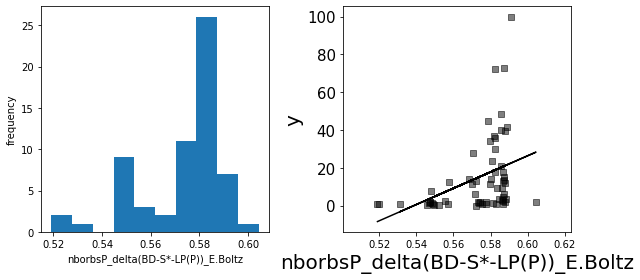

R^2 = 0.15; p-value = 2.18E-03

-------------------------------------------------------------------------------

x31 nborbsP_delta(P-MOs)_E.Boltz


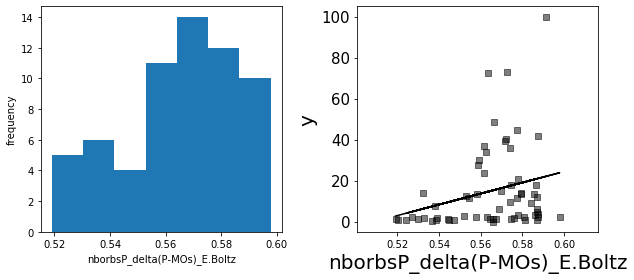

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x32 nborbsP_RY*(P)_min_E.Boltz


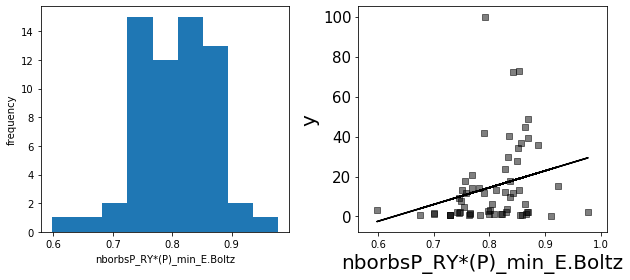

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x33 nborbsP_RY*(P)_max_Occ.Boltz


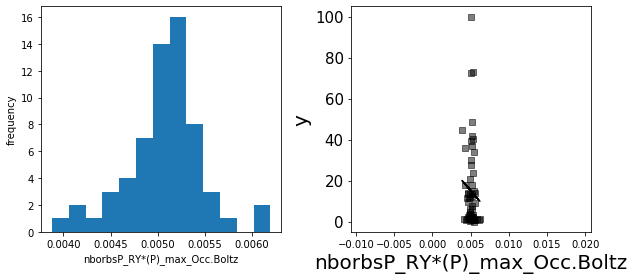

R^2 = 0.01; p-value = 0.50

-------------------------------------------------------------------------------

x34 nmr_P.Boltz


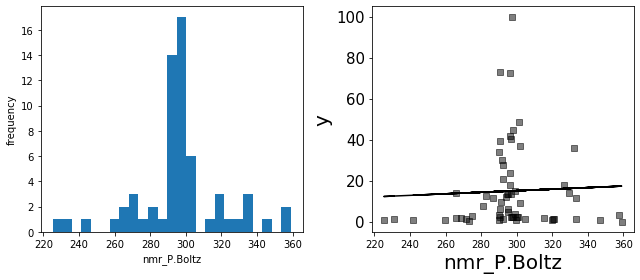

R^2 = 0.00; p-value = 0.72

-------------------------------------------------------------------------------

x35 nmrtens_sxx(P).Boltz


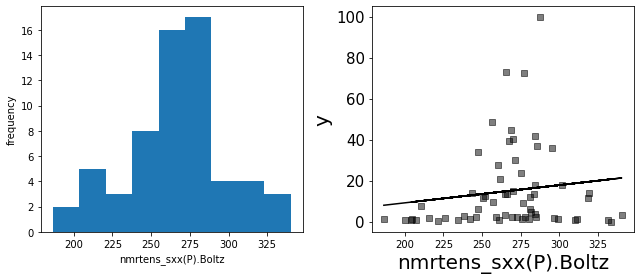

R^2 = 0.02; p-value = 0.27

-------------------------------------------------------------------------------

x36 nmrtens_syy(P).Boltz


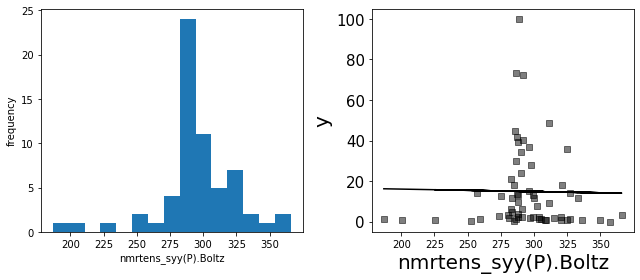

R^2 = 0.00; p-value = 0.89

-------------------------------------------------------------------------------

x37 nmrtens_szz(P).Boltz


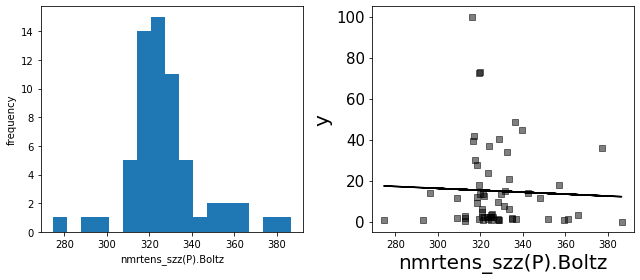

R^2 = 0.00; p-value = 0.75

-------------------------------------------------------------------------------

x38 polar_alpha_ex.Boltz


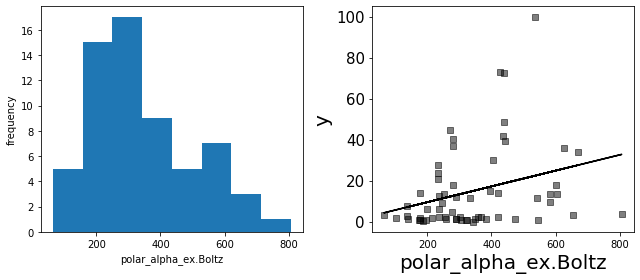

R^2 = 0.09; p-value = 0.02

-------------------------------------------------------------------------------

x39 sambvca_pvbur_150.Boltz


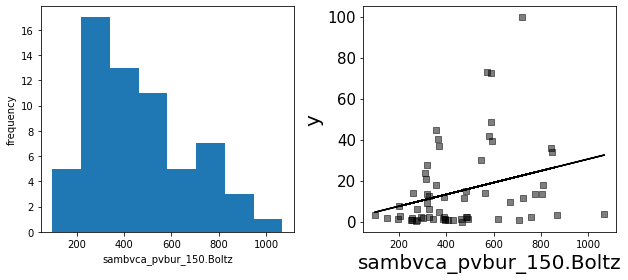

R^2 = 0.09; p-value = 0.02

-------------------------------------------------------------------------------

x40 sambvca_pvbur_Qmax_150.Boltz


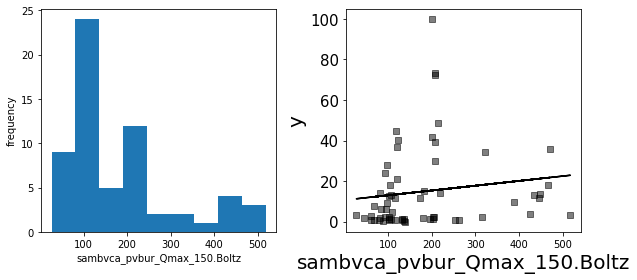

R^2 = 0.02; p-value = 0.27

-------------------------------------------------------------------------------

x41 sambvca_pvbur_vdist.Boltz


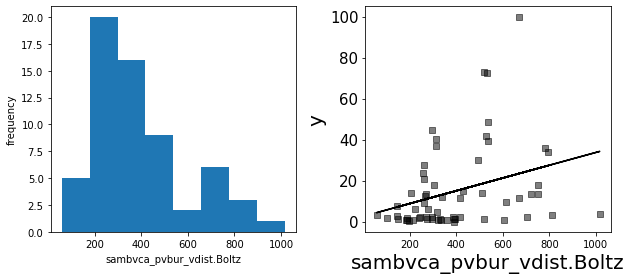

R^2 = 0.10; p-value = 0.01

-------------------------------------------------------------------------------

x42 Pint_P_int.Boltz


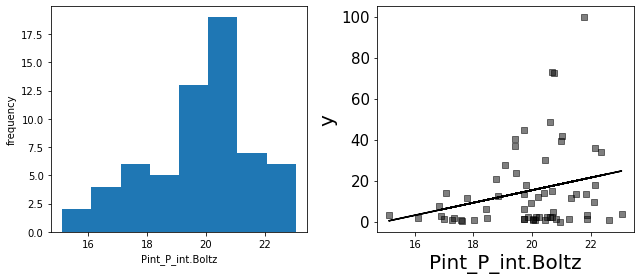

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x43 Pint_dP.Boltz


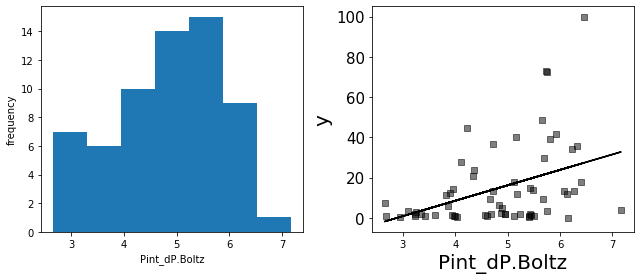

R^2 = 0.16; p-value = 1.27E-03

-------------------------------------------------------------------------------

x44 Pint_P_min.Boltz


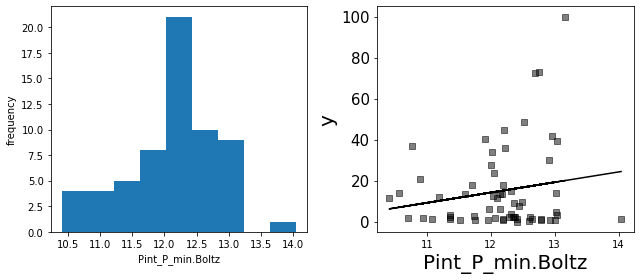

R^2 = 0.03; p-value = 0.17

-------------------------------------------------------------------------------

x45 solv_E_solv.Boltz


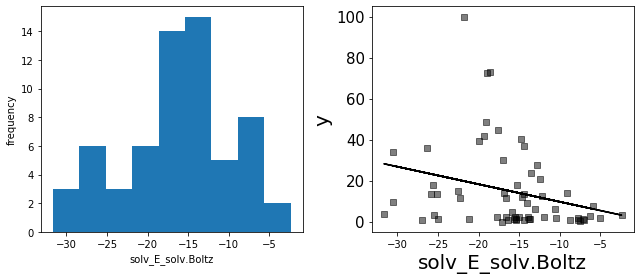

R^2 = 0.08; p-value = 0.03

-------------------------------------------------------------------------------

x46 solv_E_cds.Boltz


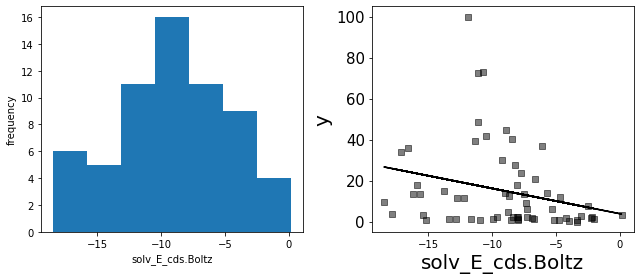

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x47 solv_E_solv_elstat.Boltz


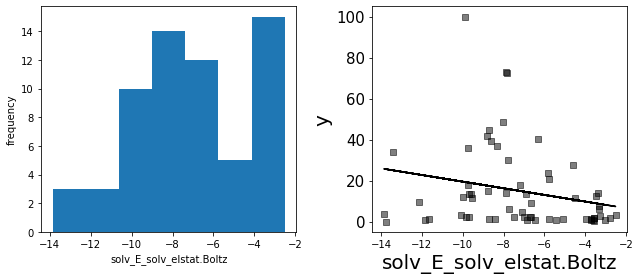

R^2 = 0.05; p-value = 0.07

-------------------------------------------------------------------------------

x48 dipole_dipole_TZ.Boltz


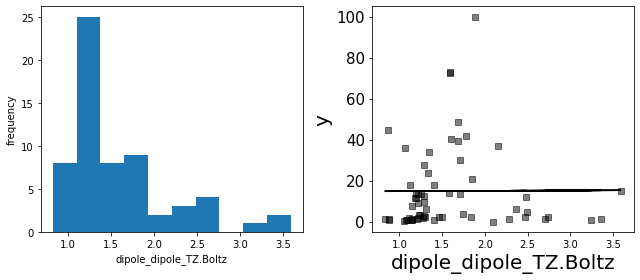

R^2 = 0.00; p-value = 0.97

-------------------------------------------------------------------------------

x49 dipole_dipole_TZ.min


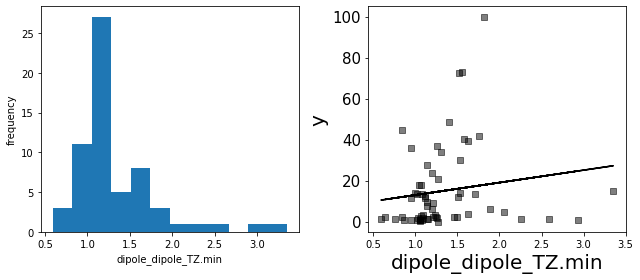

R^2 = 0.02; p-value = 0.25

-------------------------------------------------------------------------------

x50 dipole_dipole_TZ.max


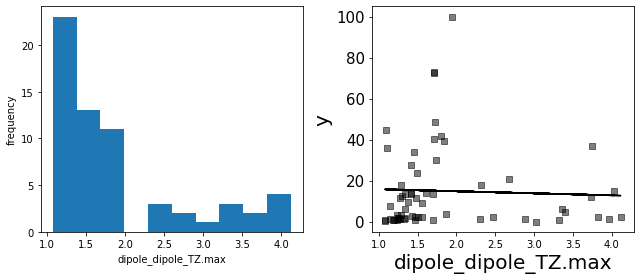

R^2 = 0.00; p-value = 0.74

-------------------------------------------------------------------------------

x51 dipole_dipole_TZ.delta


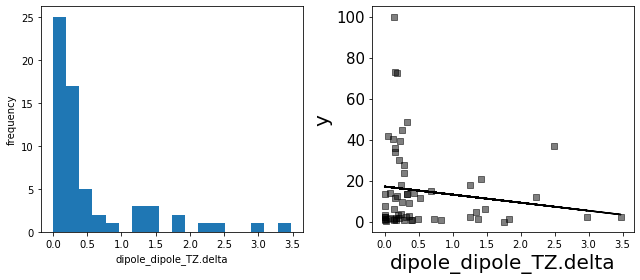

R^2 = 0.02; p-value = 0.26

-------------------------------------------------------------------------------

x52 dipole_dipole_TZ.vburmin


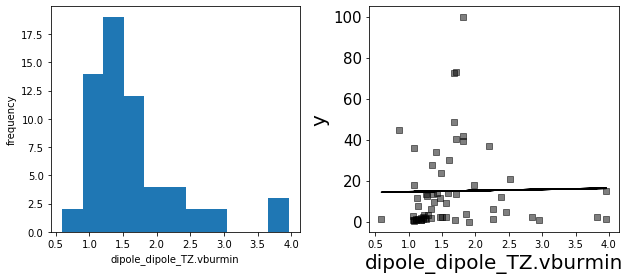

R^2 = 0.00; p-value = 0.88

-------------------------------------------------------------------------------

x53 pyr_P.Boltz


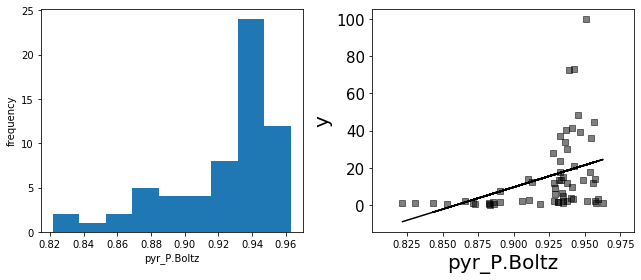

R^2 = 0.15; p-value = 1.91E-03

-------------------------------------------------------------------------------

x54 pyr_P.min


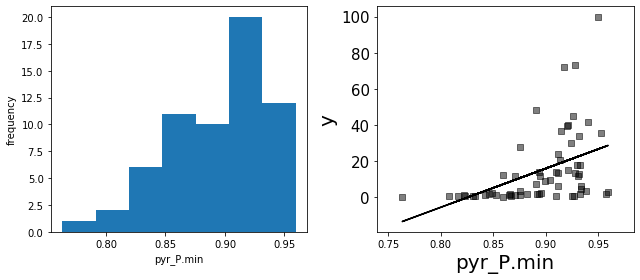

R^2 = 0.19; p-value = 3.44E-04

-------------------------------------------------------------------------------

x55 pyr_P.max


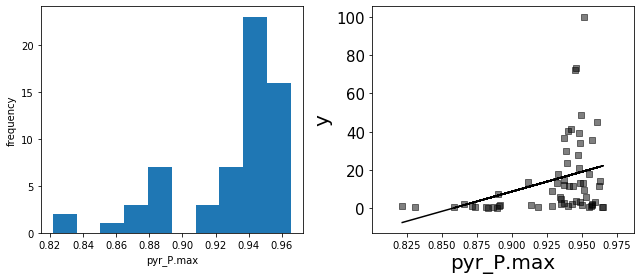

R^2 = 0.11; p-value = 7.22E-03

-------------------------------------------------------------------------------

x56 pyr_P.delta


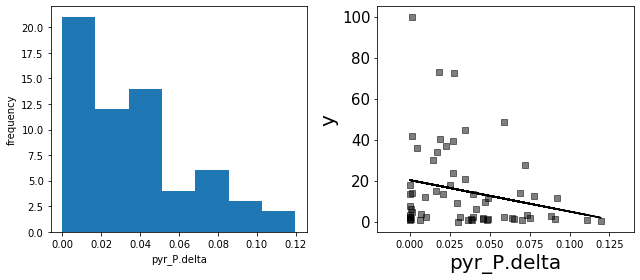

R^2 = 0.05; p-value = 0.07

-------------------------------------------------------------------------------

x57 pyr_P.vburmin


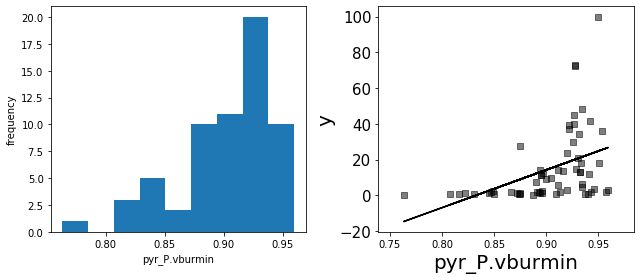

R^2 = 0.18; p-value = 6.26E-04

-------------------------------------------------------------------------------

x58 pyr_alpha.Boltz


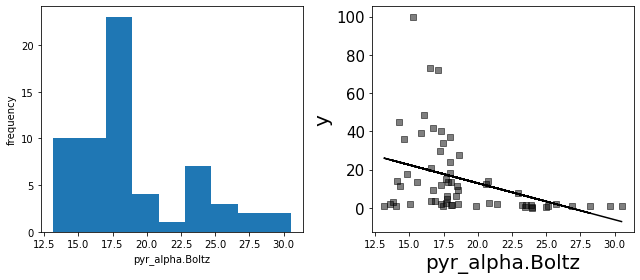

R^2 = 0.15; p-value = 2.05E-03

-------------------------------------------------------------------------------

x59 pyr_alpha.min


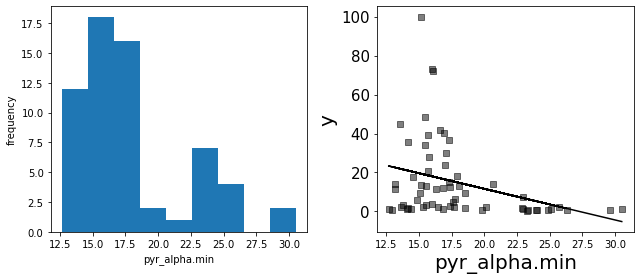

R^2 = 0.11; p-value = 8.98E-03

-------------------------------------------------------------------------------

x60 pyr_alpha.max


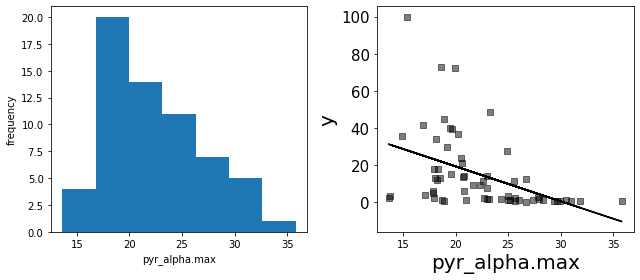

R^2 = 0.19; p-value = 3.30E-04

-------------------------------------------------------------------------------

x61 pyr_alpha.delta


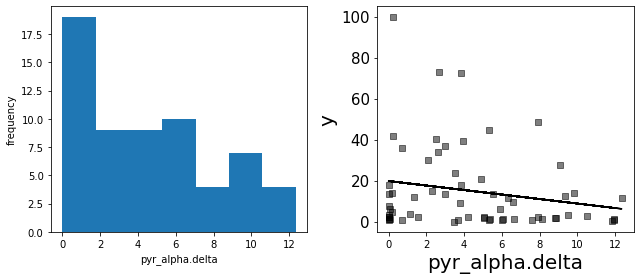

R^2 = 0.04; p-value = 0.12

-------------------------------------------------------------------------------

x62 pyr_alpha.vburmin


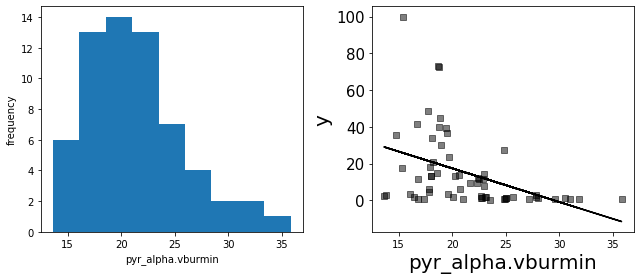

R^2 = 0.18; p-value = 6.23E-04

-------------------------------------------------------------------------------

x63 qpole_ampl.Boltz


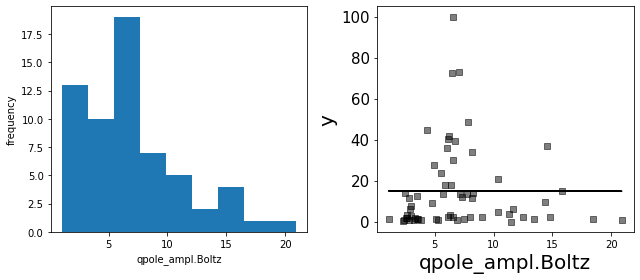

R^2 = 0.00; p-value = 0.99

-------------------------------------------------------------------------------

x64 qpole_ampl.min


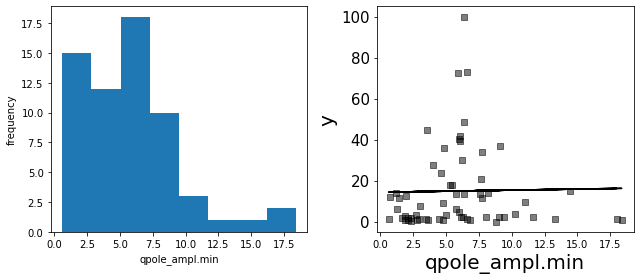

R^2 = 0.00; p-value = 0.88

-------------------------------------------------------------------------------

x65 qpole_ampl.max


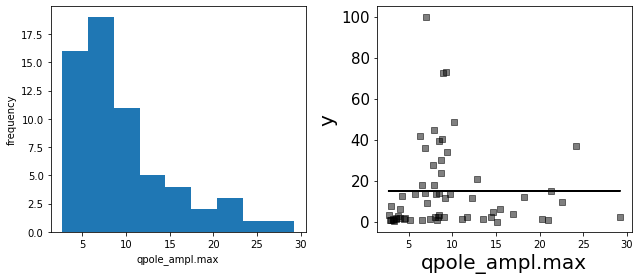

R^2 = 0.00; p-value = 1.00

-------------------------------------------------------------------------------

x66 qpole_ampl.delta


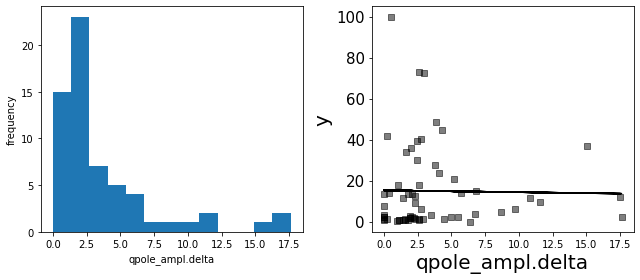

R^2 = 0.00; p-value = 0.89

-------------------------------------------------------------------------------

x67 qpole_ampl.vburmin


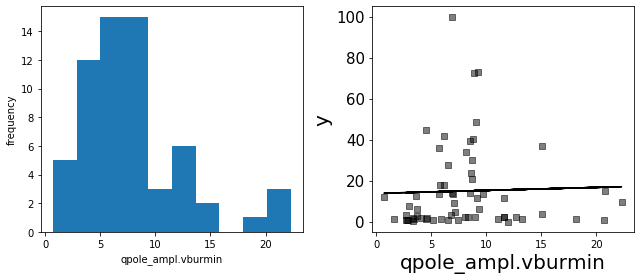

R^2 = 0.00; p-value = 0.80

-------------------------------------------------------------------------------

x68 qpole_xx.Boltz


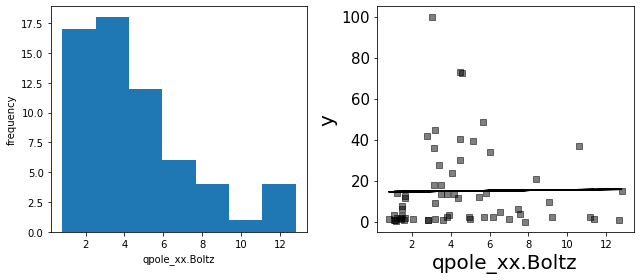

R^2 = 0.00; p-value = 0.91

-------------------------------------------------------------------------------

x69 qpole_xx.min


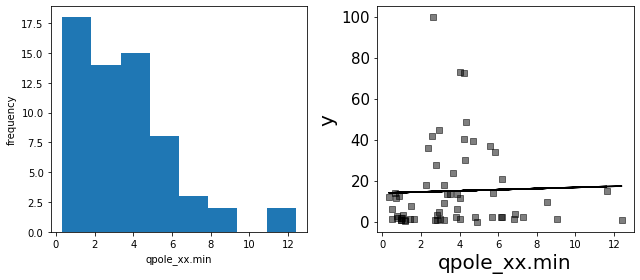

R^2 = 0.00; p-value = 0.79

-------------------------------------------------------------------------------

x70 qpole_xx.max


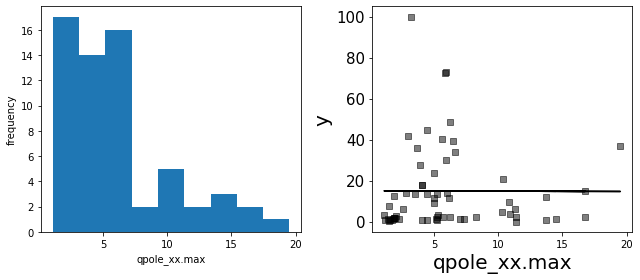

R^2 = 0.00; p-value = 0.98

-------------------------------------------------------------------------------

x71 qpole_xx.delta


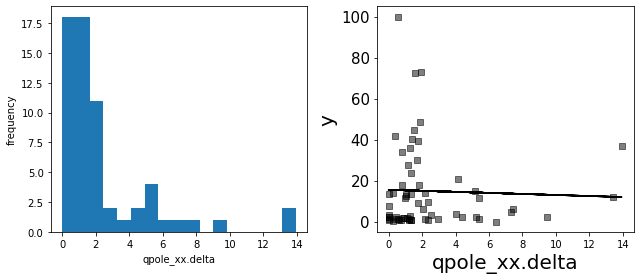

R^2 = 0.00; p-value = 0.78

-------------------------------------------------------------------------------

x72 qpole_xx.vburmin


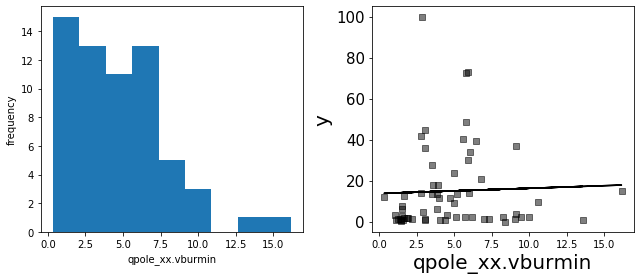

R^2 = 0.00; p-value = 0.76

-------------------------------------------------------------------------------

x73 qpole_yy.Boltz


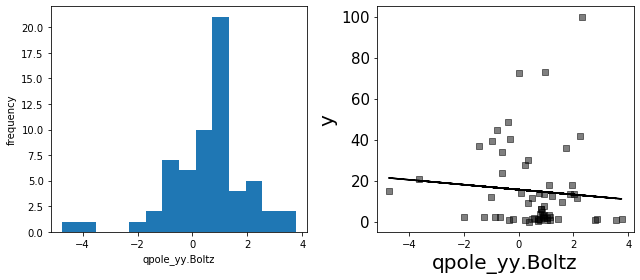

R^2 = 0.01; p-value = 0.51

-------------------------------------------------------------------------------

x74 qpole_yy.min


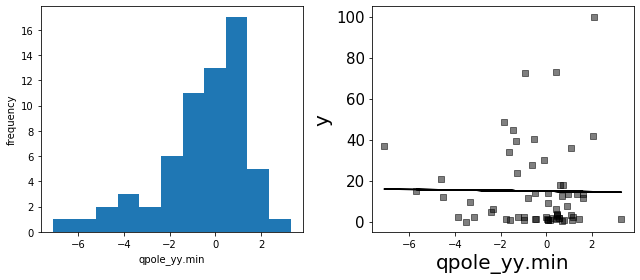

R^2 = 0.00; p-value = 0.92

-------------------------------------------------------------------------------

x75 qpole_yy.max


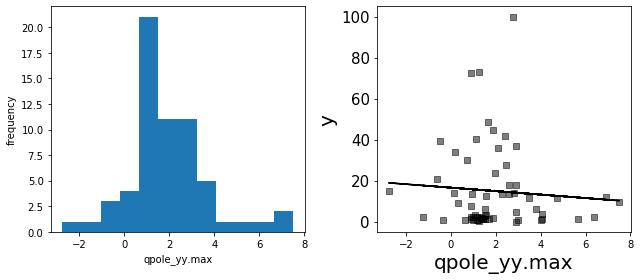

R^2 = 0.01; p-value = 0.56

-------------------------------------------------------------------------------

x76 qpole_yy.delta


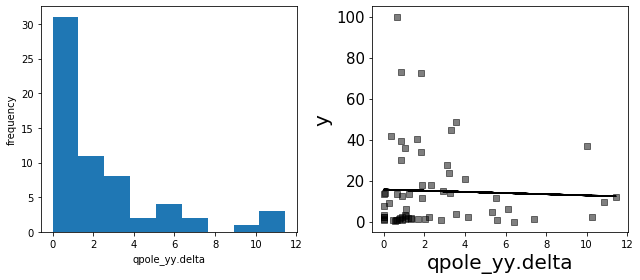

R^2 = 0.00; p-value = 0.76

-------------------------------------------------------------------------------

x77 qpole_yy.vburmin


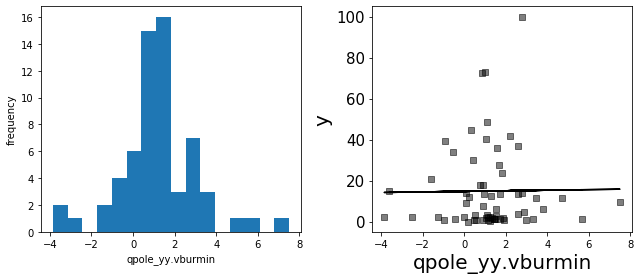

R^2 = 0.00; p-value = 0.92

-------------------------------------------------------------------------------

x78 qpole_zz.Boltz


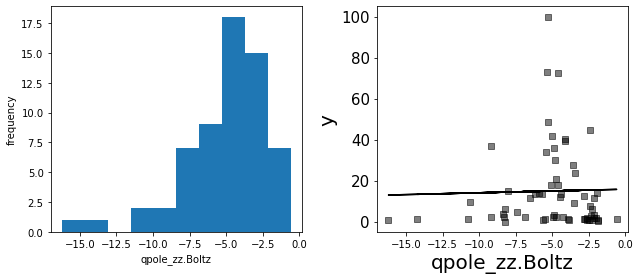

R^2 = 0.00; p-value = 0.84

-------------------------------------------------------------------------------

x79 qpole_zz.min


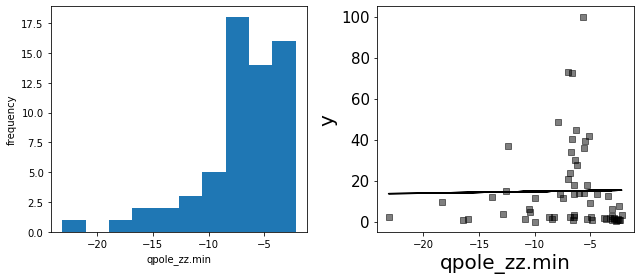

R^2 = 0.00; p-value = 0.90

-------------------------------------------------------------------------------

x80 qpole_zz.max


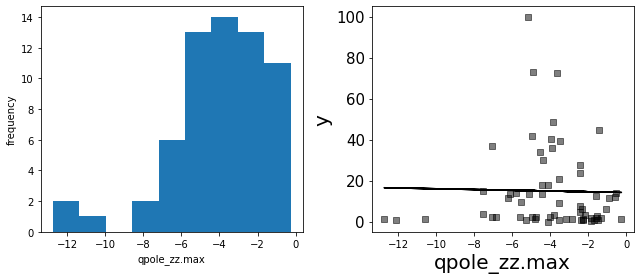

R^2 = 0.00; p-value = 0.86

-------------------------------------------------------------------------------

x81 qpole_zz.delta


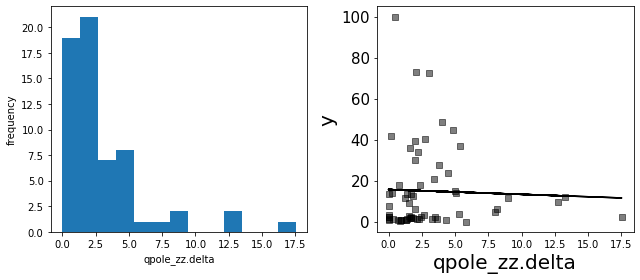

R^2 = 0.00; p-value = 0.77

-------------------------------------------------------------------------------

x82 qpole_zz.vburmin


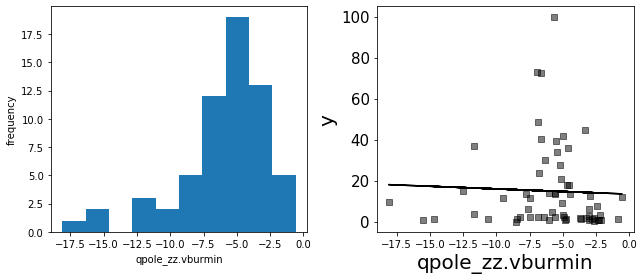

R^2 = 0.00; p-value = 0.74

-------------------------------------------------------------------------------

x83 sambvca_pvbur_35.Boltz


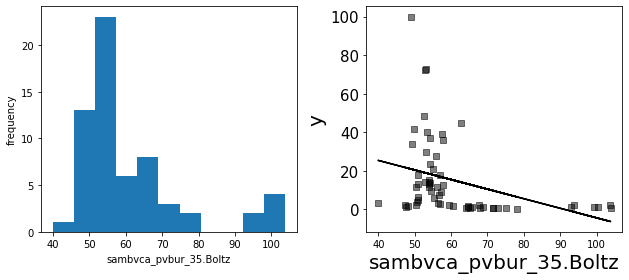

R^2 = 0.13; p-value = 4.54E-03

-------------------------------------------------------------------------------

x84 sambvca_pvbur_35.min


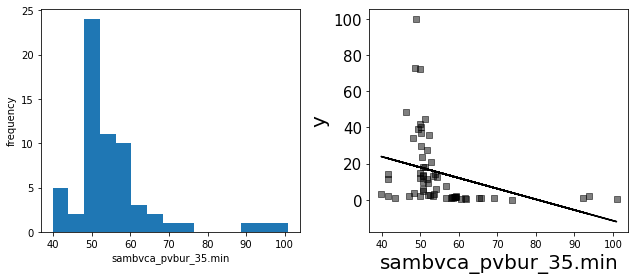

R^2 = 0.11; p-value = 0.01

-------------------------------------------------------------------------------

x85 sambvca_pvbur_35.max


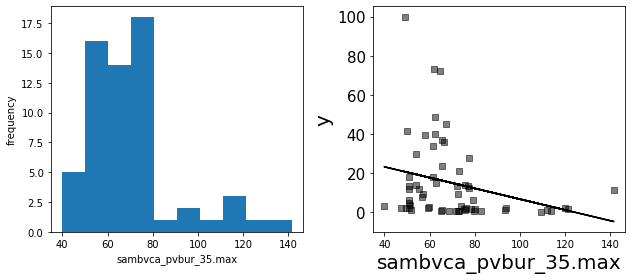

R^2 = 0.07; p-value = 0.03

-------------------------------------------------------------------------------

x86 sambvca_pvbur_35.delta


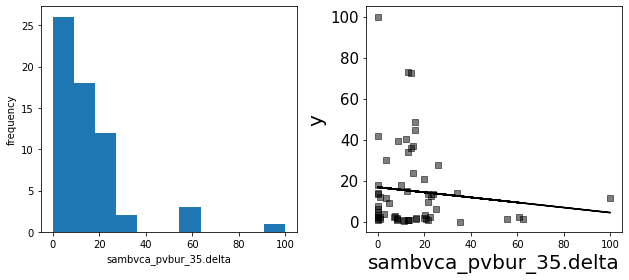

R^2 = 0.01; p-value = 0.41

-------------------------------------------------------------------------------

x87 sambvca_pvbur_35.vburmin


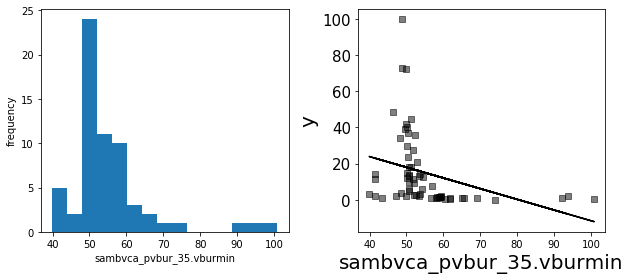

R^2 = 0.11; p-value = 0.01

-------------------------------------------------------------------------------

x88 sambvca_pvbur_Qmax_35.Boltz


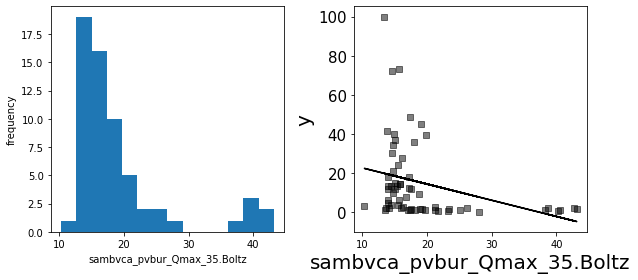

R^2 = 0.10; p-value = 0.01

-------------------------------------------------------------------------------

x89 sambvca_pvbur_Qmax_35.min


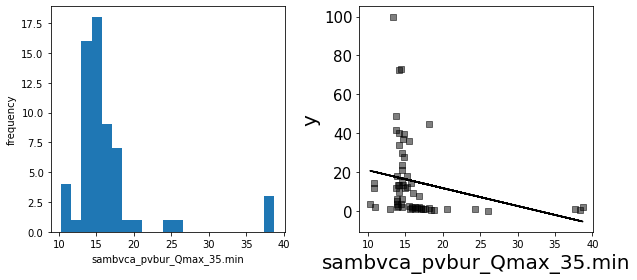

R^2 = 0.06; p-value = 0.05

-------------------------------------------------------------------------------

x90 sambvca_pvbur_Qmax_35.max


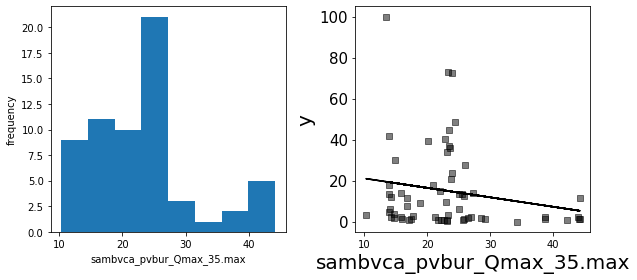

R^2 = 0.04; p-value = 0.14

-------------------------------------------------------------------------------

x91 sambvca_pvbur_Qmax_35.delta


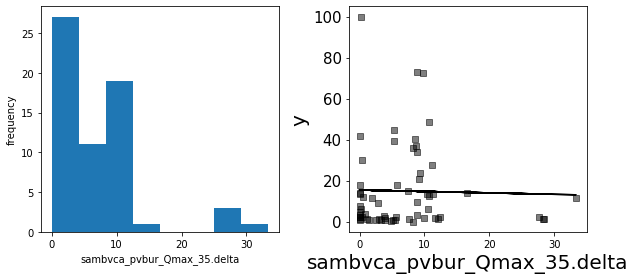

R^2 = 0.00; p-value = 0.84

-------------------------------------------------------------------------------

x92 sambvca_pvbur_Qmax_35.vburmin


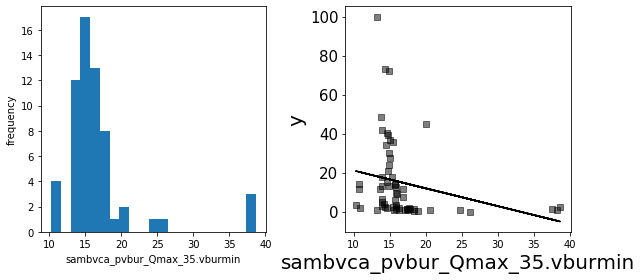

R^2 = 0.06; p-value = 0.05

-------------------------------------------------------------------------------

x93 sambvca_pvbur_Qmin_150.Boltz


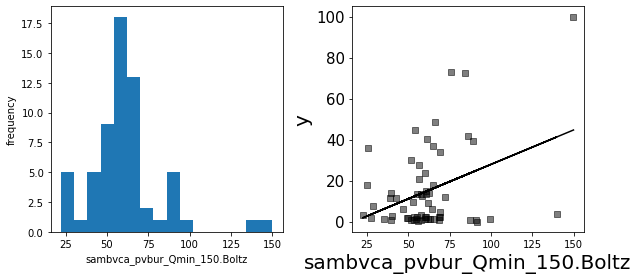

R^2 = 0.14; p-value = 2.93E-03

-------------------------------------------------------------------------------

x94 sambvca_pvbur_Qmin_150.min


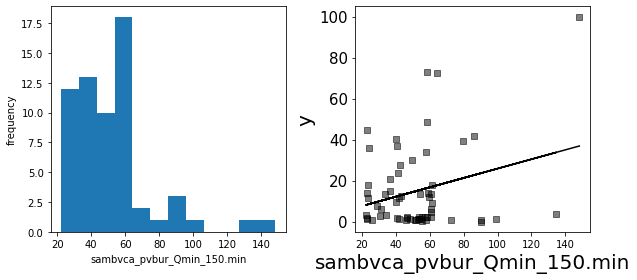

R^2 = 0.07; p-value = 0.03

-------------------------------------------------------------------------------

x95 sambvca_pvbur_Qmin_150.max


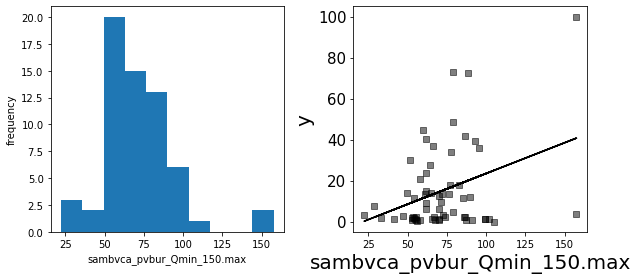

R^2 = 0.12; p-value = 5.69E-03

-------------------------------------------------------------------------------

x96 sambvca_pvbur_Qmin_150.delta


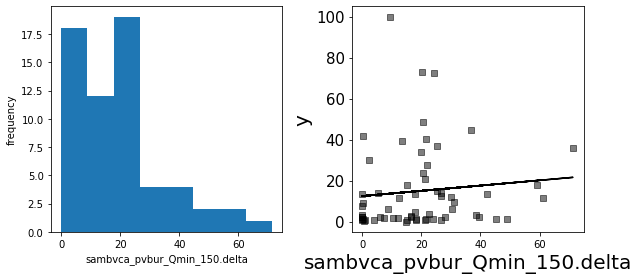

R^2 = 0.01; p-value = 0.43

-------------------------------------------------------------------------------

x97 sambvca_pvbur_Qmin_150.vburmin


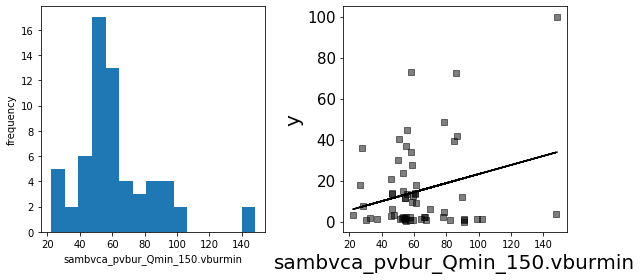

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x98 sambvca_pvbur_Qmin_35.Boltz


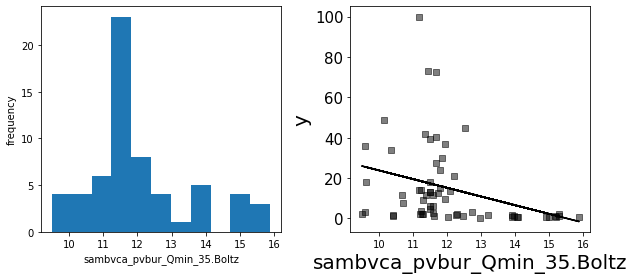

R^2 = 0.11; p-value = 9.82E-03

-------------------------------------------------------------------------------

x99 sambvca_pvbur_Qmin_35.min


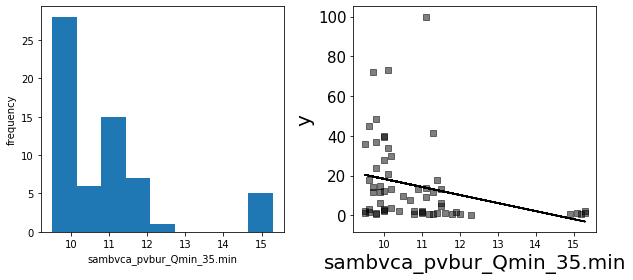

R^2 = 0.09; p-value = 0.02

-------------------------------------------------------------------------------

x100 sambvca_pvbur_Qmin_35.max


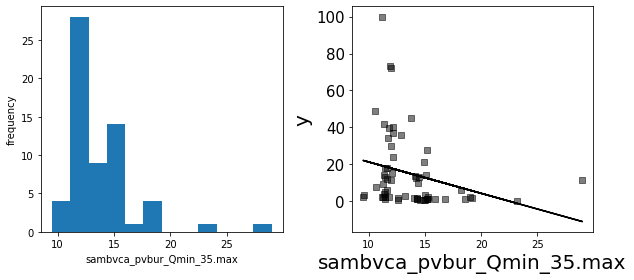

R^2 = 0.07; p-value = 0.03

-------------------------------------------------------------------------------

x101 sambvca_pvbur_Qmin_35.delta


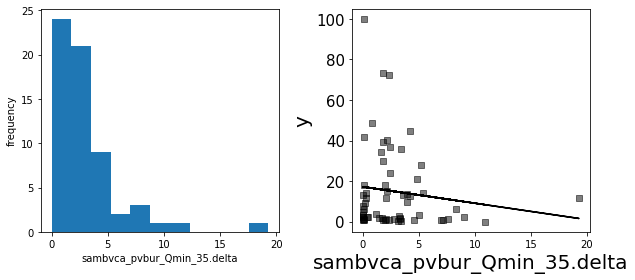

R^2 = 0.02; p-value = 0.31

-------------------------------------------------------------------------------

x102 sambvca_pvbur_Qmin_35.vburmin


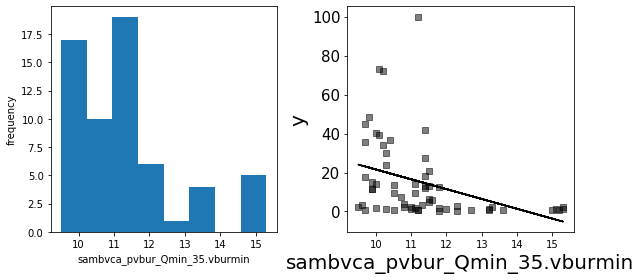

R^2 = 0.14; p-value = 2.76E-03

-------------------------------------------------------------------------------

x103 sambvca_pvbur_maxdeltaQneigh_150.Boltz


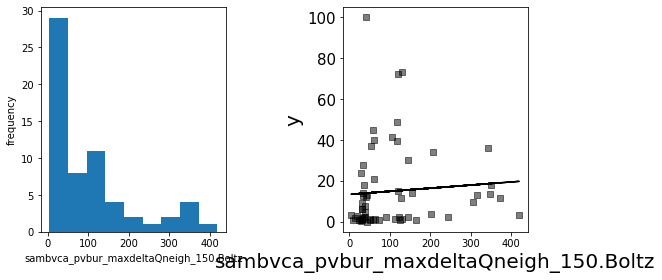

R^2 = 0.01; p-value = 0.55

-------------------------------------------------------------------------------

x104 sambvca_pvbur_maxdeltaQneigh_150.min


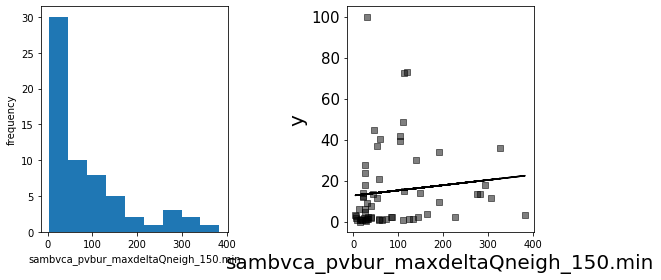

R^2 = 0.01; p-value = 0.38

-------------------------------------------------------------------------------

x105 sambvca_pvbur_maxdeltaQneigh_150.max


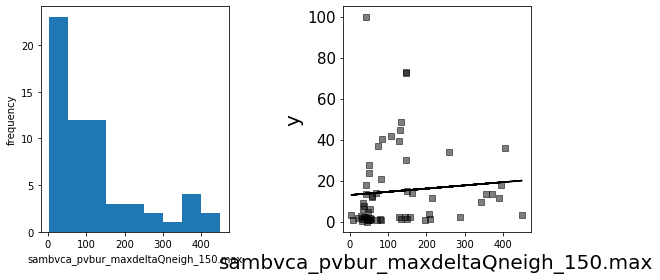

R^2 = 0.01; p-value = 0.50

-------------------------------------------------------------------------------

x106 sambvca_pvbur_maxdeltaQneigh_150.delta


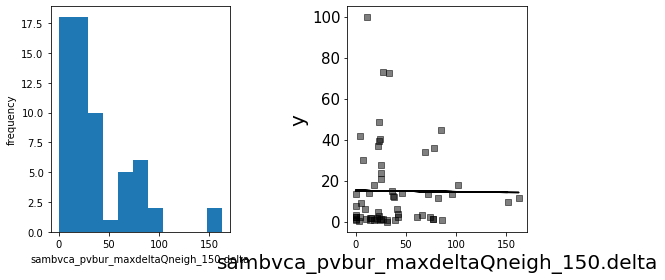

R^2 = 0.00; p-value = 0.94

-------------------------------------------------------------------------------

x107 sambvca_pvbur_maxdeltaQneigh_150.vburmin


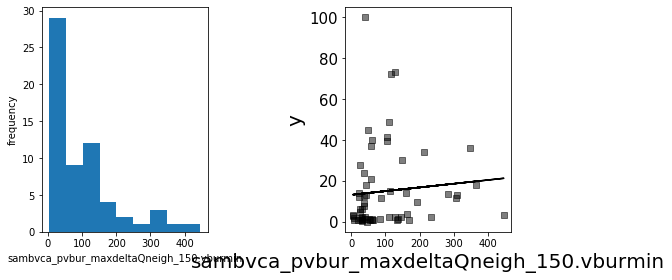

R^2 = 0.01; p-value = 0.50

-------------------------------------------------------------------------------

x108 sambvca_pvbur_maxdeltaQneigh_35.Boltz


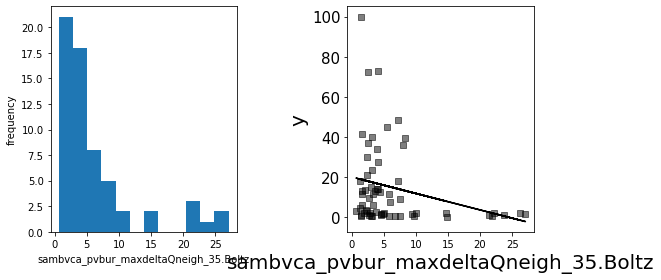

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x109 sambvca_pvbur_maxdeltaQneigh_35.min


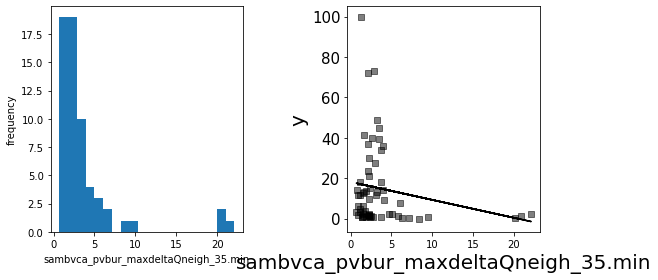

R^2 = 0.04; p-value = 0.14

-------------------------------------------------------------------------------

x110 sambvca_pvbur_maxdeltaQneigh_35.max


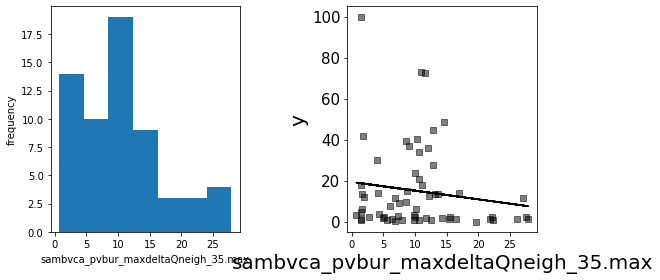

R^2 = 0.02; p-value = 0.26

-------------------------------------------------------------------------------

x111 sambvca_pvbur_maxdeltaQneigh_35.delta


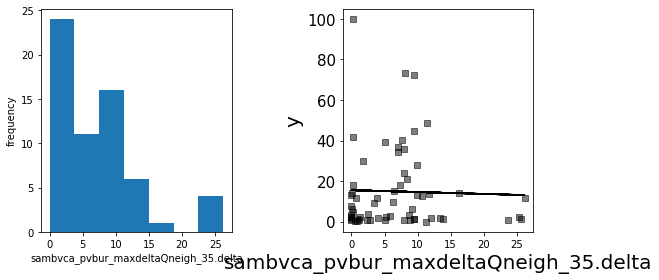

R^2 = 0.00; p-value = 0.82

-------------------------------------------------------------------------------

x112 sambvca_pvbur_maxdeltaQneigh_35.vburmin


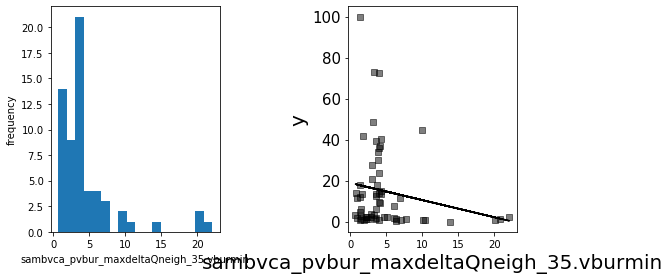

R^2 = 0.03; p-value = 0.15

-------------------------------------------------------------------------------

x113 sambvca_pvbur_vprox/vdist.Boltz


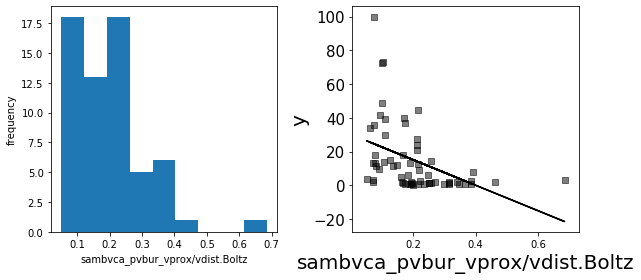

R^2 = 0.18; p-value = 5.07E-04

-------------------------------------------------------------------------------

x114 sambvca_pvbur_vprox/vdist.min


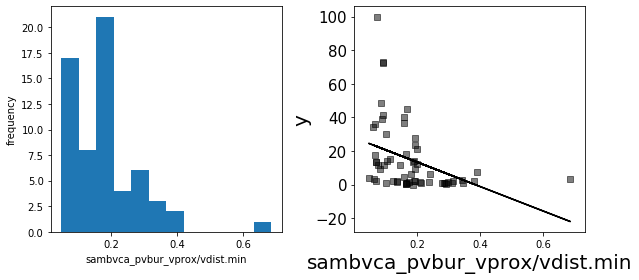

R^2 = 0.15; p-value = 1.79E-03

-------------------------------------------------------------------------------

x115 sambvca_pvbur_vprox/vdist.max


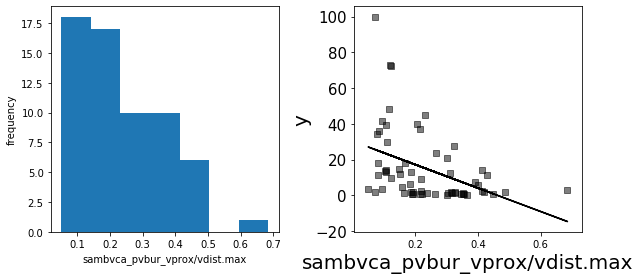

R^2 = 0.18; p-value = 7.12E-04

-------------------------------------------------------------------------------

x116 sambvca_pvbur_vprox/vdist.delta


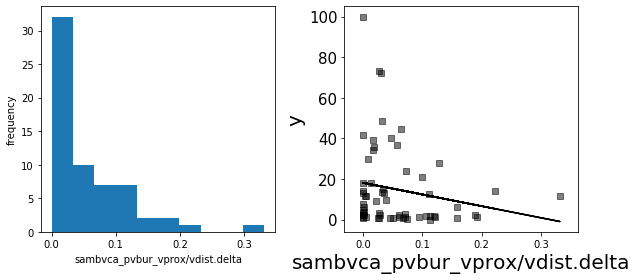

R^2 = 0.03; p-value = 0.15

-------------------------------------------------------------------------------

x117 sambvca_pvbur_vprox/vdist.vburmin


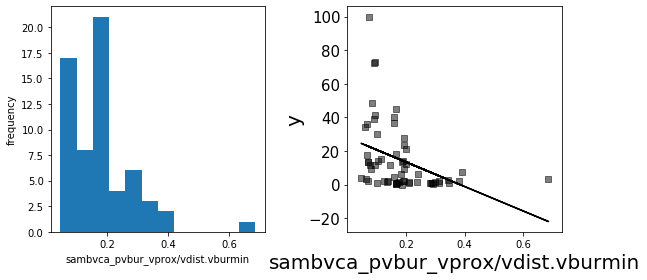

R^2 = 0.15; p-value = 1.79E-03

-------------------------------------------------------------------------------

x118 sterimol_5-.5cB1.Boltz


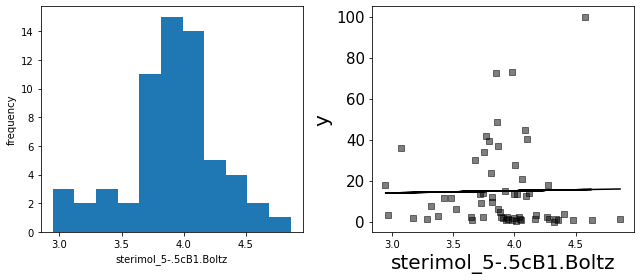

R^2 = 0.00; p-value = 0.88

-------------------------------------------------------------------------------

x119 sterimol_5-.5cB1.min


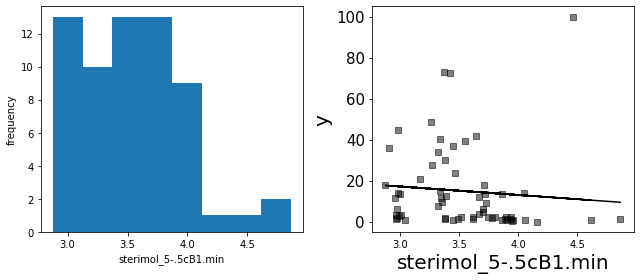

R^2 = 0.01; p-value = 0.50

-------------------------------------------------------------------------------

x120 sterimol_5-.5cB1.max


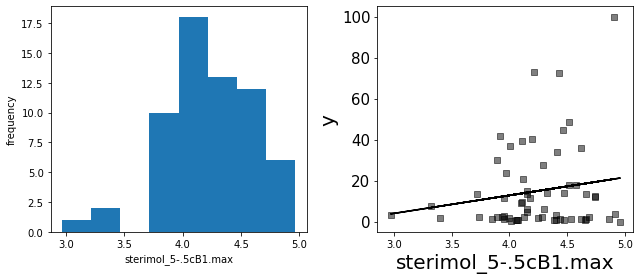

R^2 = 0.03; p-value = 0.20

-------------------------------------------------------------------------------

x121 sterimol_5-.5cB1.delta


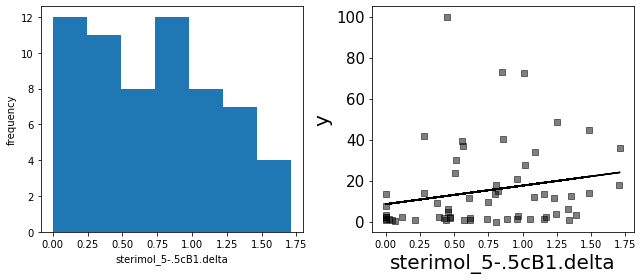

R^2 = 0.05; p-value = 0.10

-------------------------------------------------------------------------------

x122 sterimol_5-.5cB1.vburmin


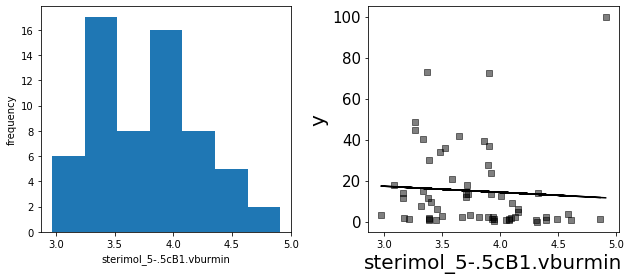

R^2 = 0.00; p-value = 0.61

-------------------------------------------------------------------------------

x123 sterimol_5-.5cB5.Boltz


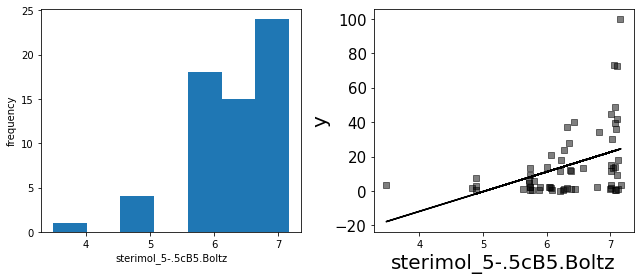

R^2 = 0.17; p-value = 7.18E-04

-------------------------------------------------------------------------------

x124 sterimol_5-.5cB5.min


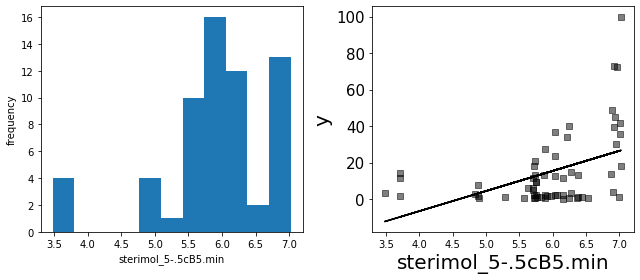

R^2 = 0.20; p-value = 2.55E-04

-------------------------------------------------------------------------------

x125 sterimol_5-.5cB5.max


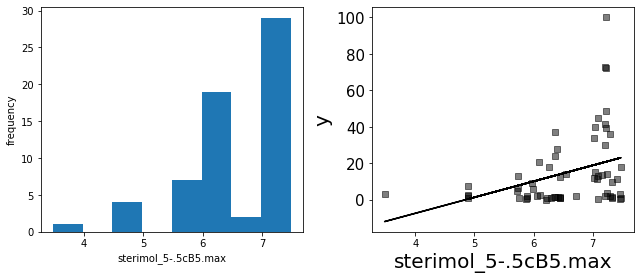

R^2 = 0.12; p-value = 5.39E-03

-------------------------------------------------------------------------------

x126 sterimol_5-.5cB5.delta


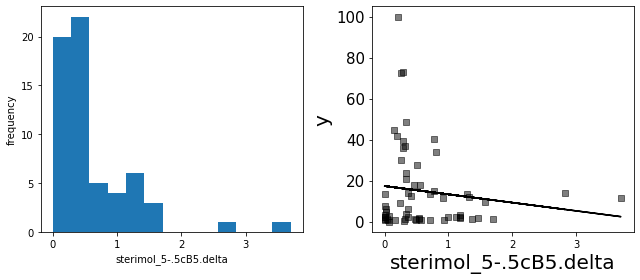

R^2 = 0.02; p-value = 0.30

-------------------------------------------------------------------------------

x127 sterimol_5-.5cB5.vburmin


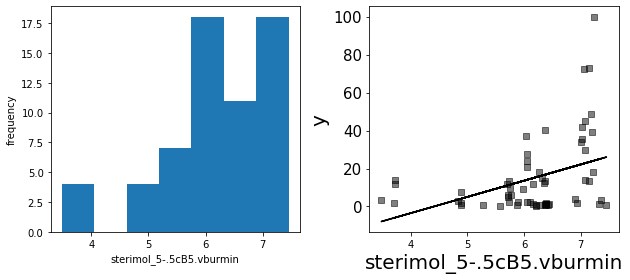

R^2 = 0.15; p-value = 1.76E-03

-------------------------------------------------------------------------------

x128 sterimol_B1.Boltz


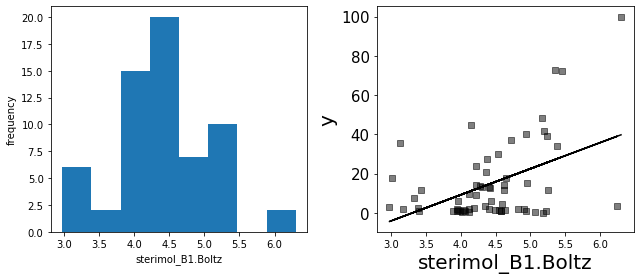

R^2 = 0.20; p-value = 2.20E-04

-------------------------------------------------------------------------------

x129 sterimol_B1.min


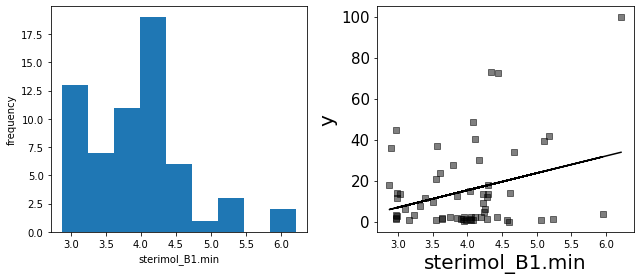

R^2 = 0.09; p-value = 0.02

-------------------------------------------------------------------------------

x130 sterimol_B1.max


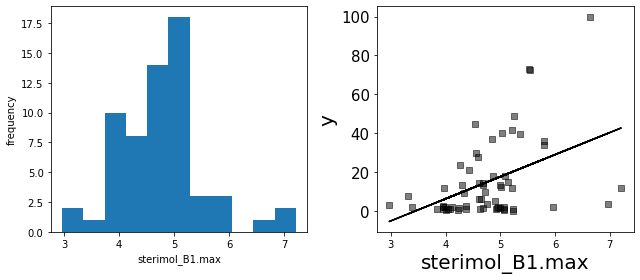

R^2 = 0.19; p-value = 4.72E-04

-------------------------------------------------------------------------------

x131 sterimol_B1.delta


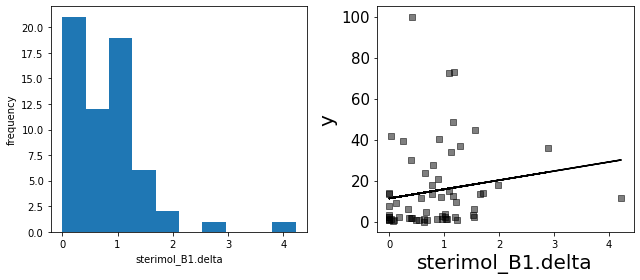

R^2 = 0.03; p-value = 0.21

-------------------------------------------------------------------------------

x132 sterimol_B1.vburmin


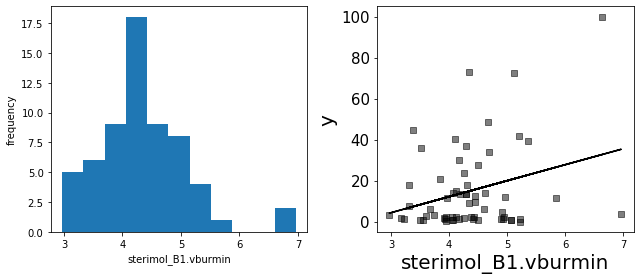

R^2 = 0.08; p-value = 0.02

-------------------------------------------------------------------------------

x133 sterimol_B5.Boltz


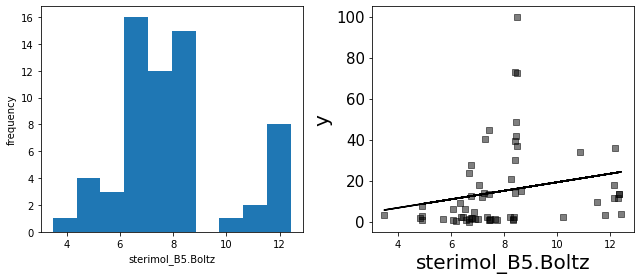

R^2 = 0.05; p-value = 0.09

-------------------------------------------------------------------------------

x134 sterimol_B5.min


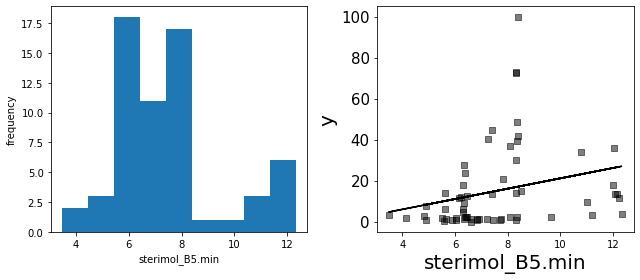

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x135 sterimol_B5.max


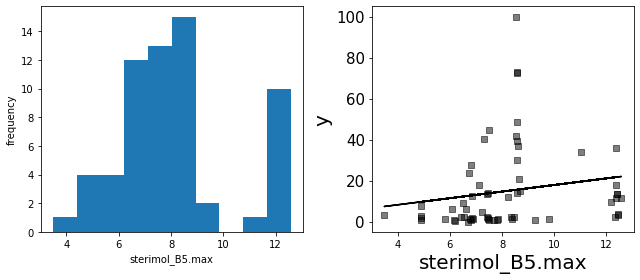

R^2 = 0.03; p-value = 0.17

-------------------------------------------------------------------------------

x136 sterimol_B5.delta


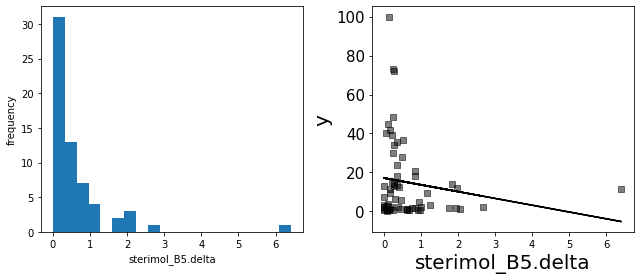

R^2 = 0.03; p-value = 0.21

-------------------------------------------------------------------------------

x137 sterimol_B5.vburmin


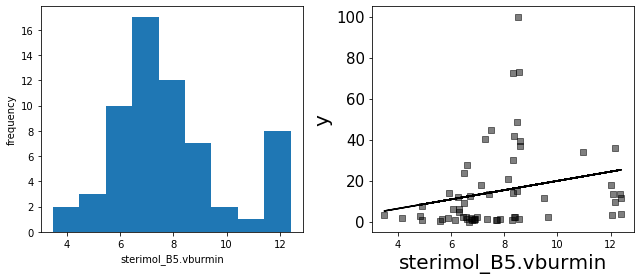

R^2 = 0.06; p-value = 0.06

-------------------------------------------------------------------------------

x138 sterimol_lval.Boltz


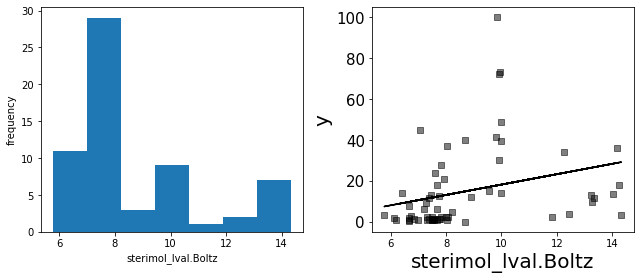

R^2 = 0.08; p-value = 0.02

-------------------------------------------------------------------------------

x139 sterimol_lval.min


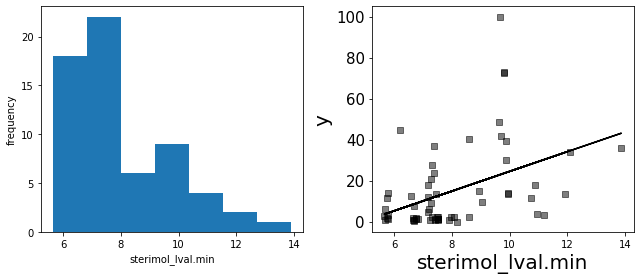

R^2 = 0.18; p-value = 5.01E-04

-------------------------------------------------------------------------------

x140 sterimol_lval.max


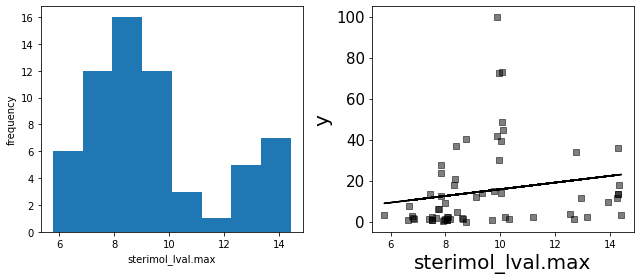

R^2 = 0.04; p-value = 0.14

-------------------------------------------------------------------------------

x141 sterimol_lval.delta


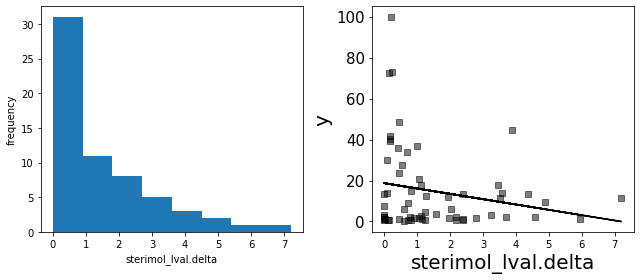

R^2 = 0.04; p-value = 0.11

-------------------------------------------------------------------------------

x142 sterimol_lval.vburmin


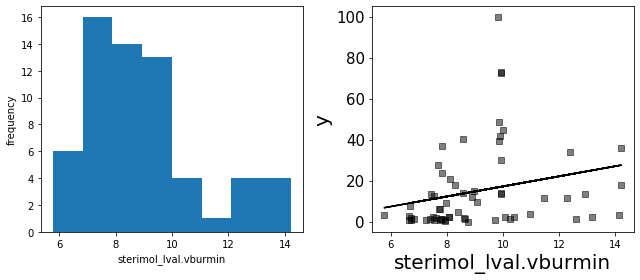

R^2 = 0.06; p-value = 0.06

-------------------------------------------------------------------------------

x143 visvol_tot_visvol.Boltz


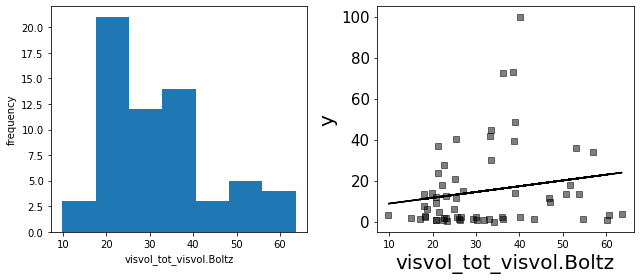

R^2 = 0.03; p-value = 0.16

-------------------------------------------------------------------------------

x144 visvol_tot_visvol.min


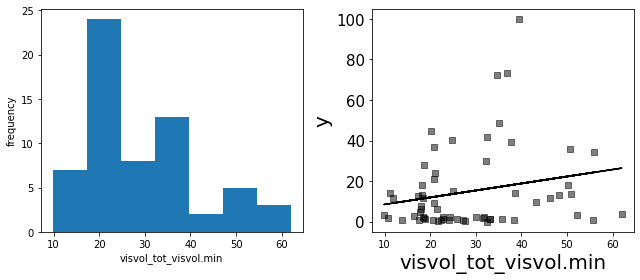

R^2 = 0.05; p-value = 0.09

-------------------------------------------------------------------------------

x145 visvol_tot_visvol.max


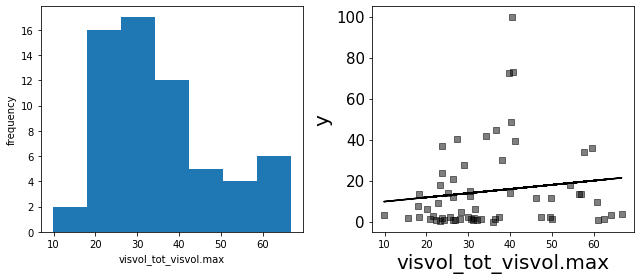

R^2 = 0.02; p-value = 0.28

-------------------------------------------------------------------------------

x146 visvol_tot_visvol.delta


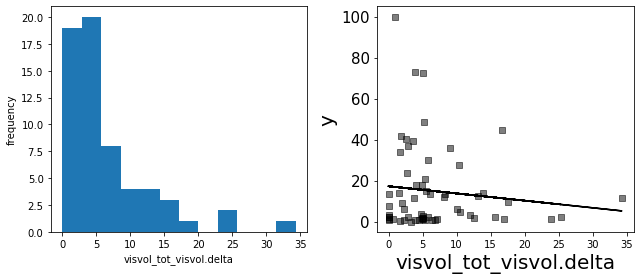

R^2 = 0.01; p-value = 0.37

-------------------------------------------------------------------------------

x147 visvol_tot_visvol.vburmin


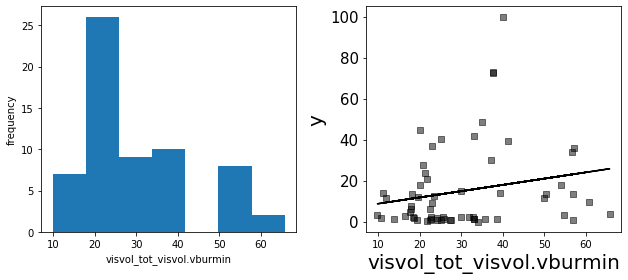

R^2 = 0.04; p-value = 0.10

-------------------------------------------------------------------------------

x148 visvol_prox_visvol.Boltz


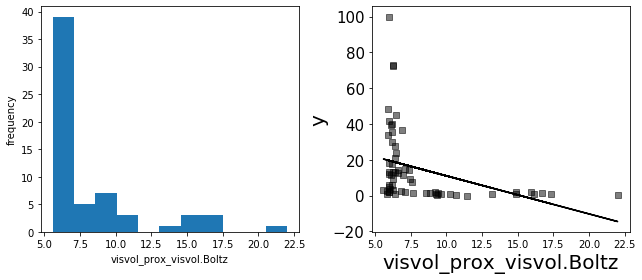

R^2 = 0.14; p-value = 2.97E-03

-------------------------------------------------------------------------------

x149 visvol_prox_visvol.min


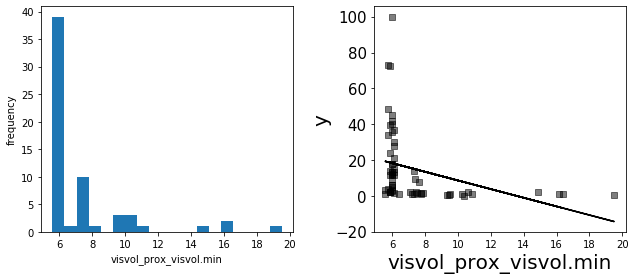

R^2 = 0.11; p-value = 7.21E-03

-------------------------------------------------------------------------------

x150 visvol_prox_visvol.max


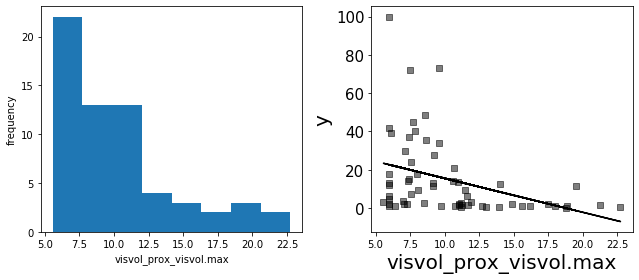

R^2 = 0.14; p-value = 3.10E-03

-------------------------------------------------------------------------------

x151 visvol_prox_visvol.delta


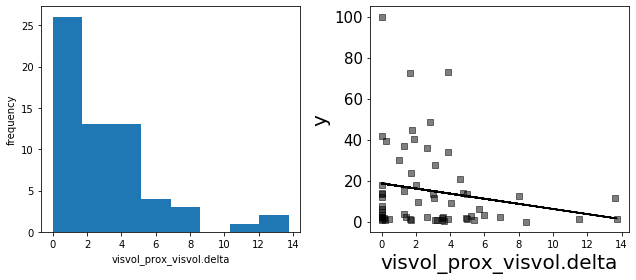

R^2 = 0.04; p-value = 0.13

-------------------------------------------------------------------------------

x152 visvol_prox_visvol.vburmin


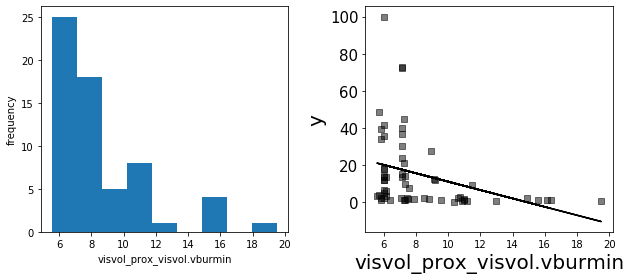

R^2 = 0.12; p-value = 6.54E-03

-------------------------------------------------------------------------------

x153 visvol_dist_visvol.Boltz


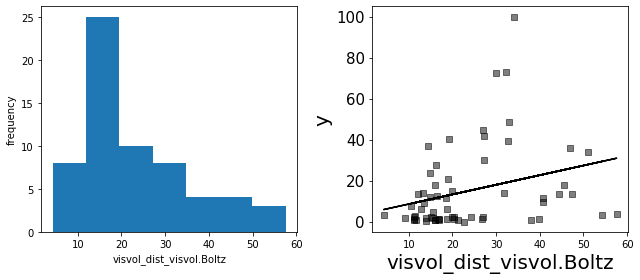

R^2 = 0.08; p-value = 0.02

-------------------------------------------------------------------------------

x154 visvol_dist_visvol.min


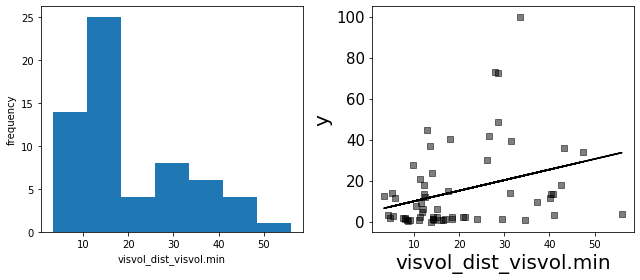

R^2 = 0.10; p-value = 0.01

-------------------------------------------------------------------------------

x155 visvol_dist_visvol.max


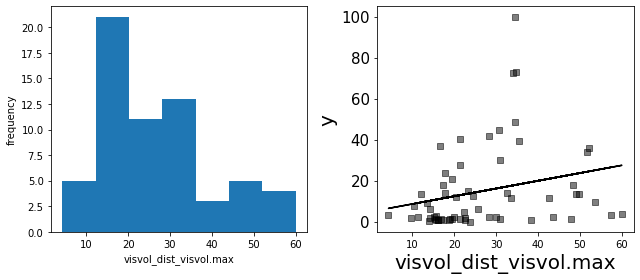

R^2 = 0.06; p-value = 0.05

-------------------------------------------------------------------------------

x156 visvol_dist_visvol.delta


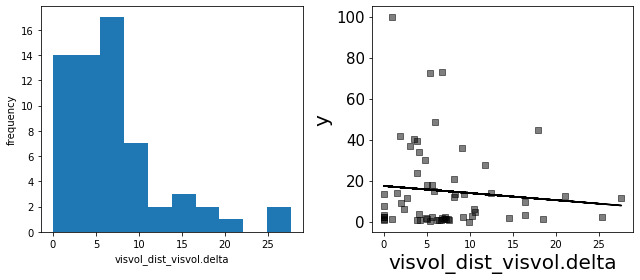

R^2 = 0.01; p-value = 0.43

-------------------------------------------------------------------------------

x157 visvol_dist_visvol.vburmin


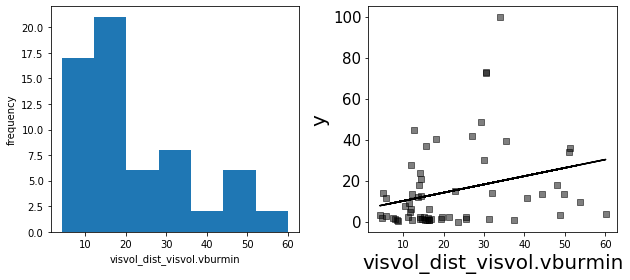

R^2 = 0.08; p-value = 0.03

-------------------------------------------------------------------------------

x158 visvol_ratio_vis_tot.Boltz


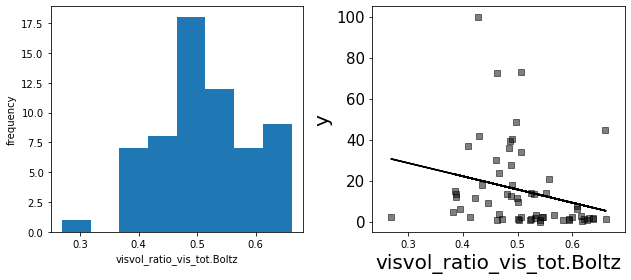

R^2 = 0.07; p-value = 0.04

-------------------------------------------------------------------------------

x159 visvol_ratio_vis_tot.min


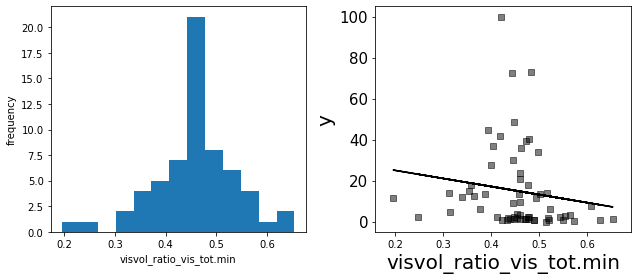

R^2 = 0.02; p-value = 0.23

-------------------------------------------------------------------------------

x160 visvol_ratio_vis_tot.max


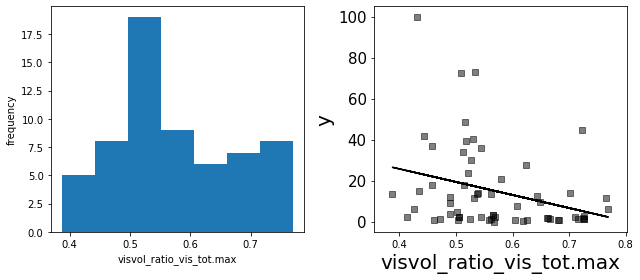

R^2 = 0.09; p-value = 0.02

-------------------------------------------------------------------------------

x161 visvol_ratio_vis_tot.delta


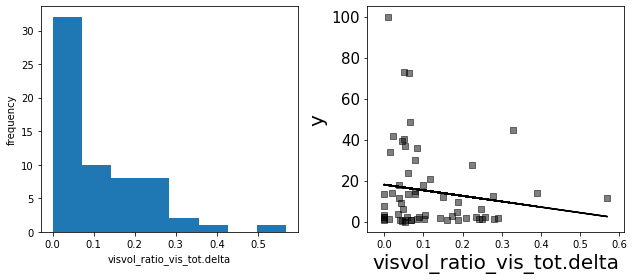

R^2 = 0.02; p-value = 0.24

-------------------------------------------------------------------------------

x162 visvol_ratio_vis_tot.vburmin


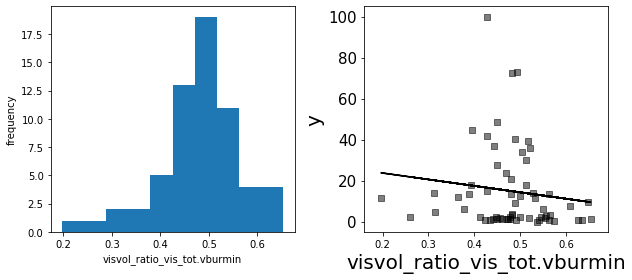

R^2 = 0.02; p-value = 0.31

-------------------------------------------------------------------------------

x163 visvol_ratio_distvis_proxvis.Boltz


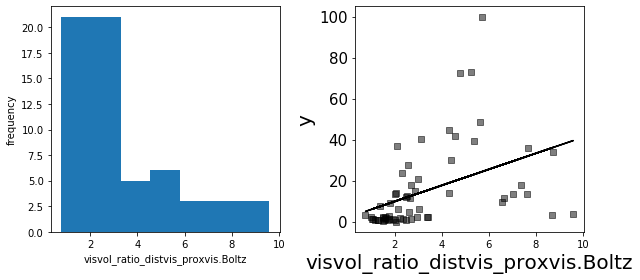

R^2 = 0.18; p-value = 5.33E-04

-------------------------------------------------------------------------------

x164 visvol_ratio_distvis_proxvis.min


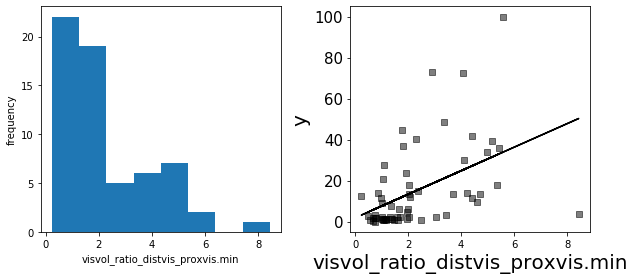

R^2 = 0.22; p-value = 1.05E-04

-------------------------------------------------------------------------------

x165 visvol_ratio_distvis_proxvis.max


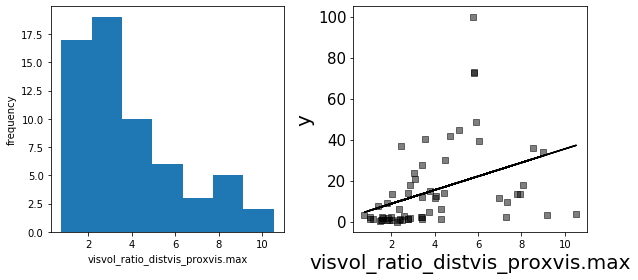

R^2 = 0.15; p-value = 1.77E-03

-------------------------------------------------------------------------------

x166 visvol_ratio_distvis_proxvis.delta


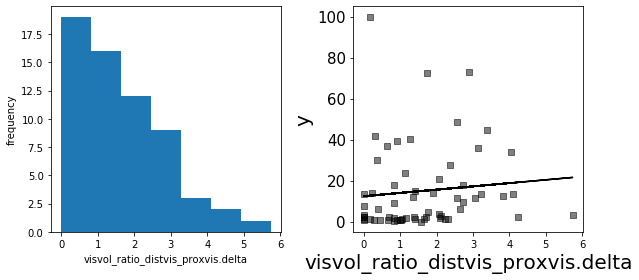

R^2 = 0.01; p-value = 0.44

-------------------------------------------------------------------------------

x167 visvol_ratio_distvis_proxvis.vburmin


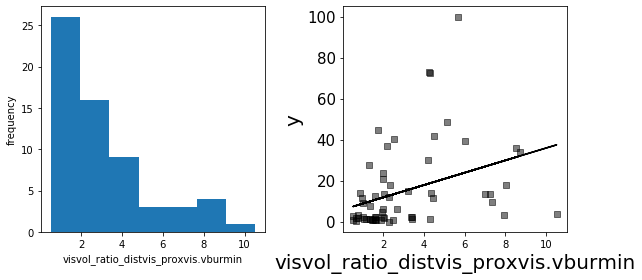

R^2 = 0.13; p-value = 4.58E-03

-------------------------------------------------------------------------------

x168 Pint_P_max.Boltz


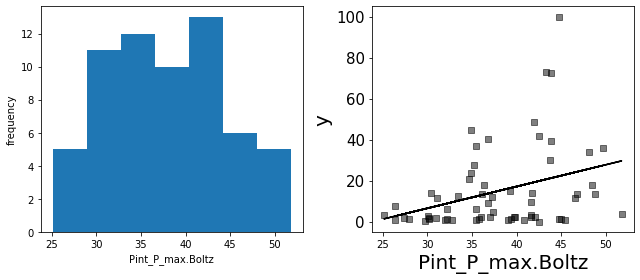

R^2 = 0.11; p-value = 7.24E-03

-------------------------------------------------------------------------------

x169 Pint_P_max.min


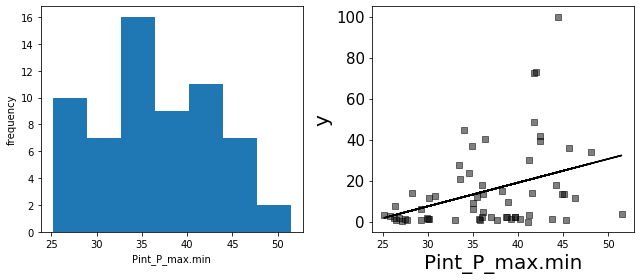

R^2 = 0.14; p-value = 3.30E-03

-------------------------------------------------------------------------------

x170 Pint_P_max.max


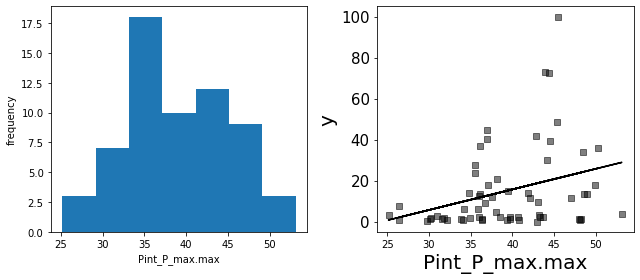

R^2 = 0.10; p-value = 0.01

-------------------------------------------------------------------------------

x171 Pint_P_max.delta


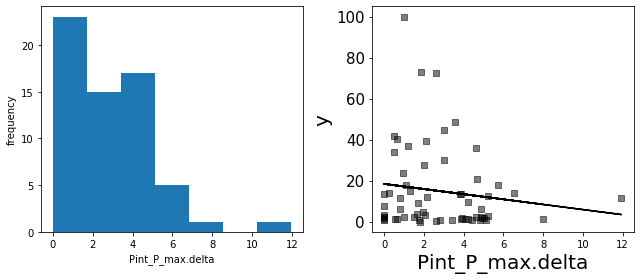

R^2 = 0.02; p-value = 0.28

-------------------------------------------------------------------------------

x172 Pint_P_max.vburmin


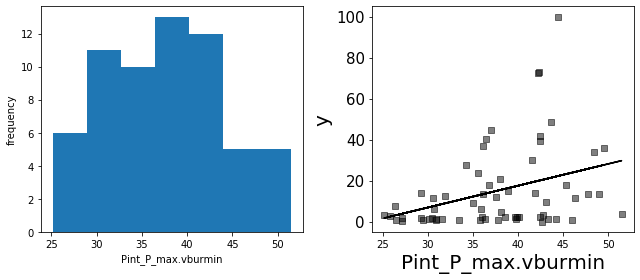

R^2 = 0.12; p-value = 5.72E-03

-------------------------------------------------------------------------------

x173 Pint_SurfArea.Boltz


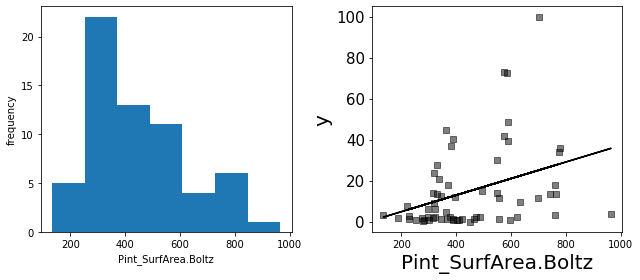

R^2 = 0.13; p-value = 4.76E-03

-------------------------------------------------------------------------------

x174 Pint_SurfArea.min


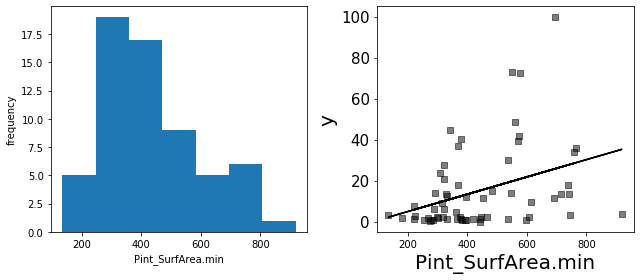

R^2 = 0.13; p-value = 4.31E-03

-------------------------------------------------------------------------------

x175 Pint_SurfArea.max


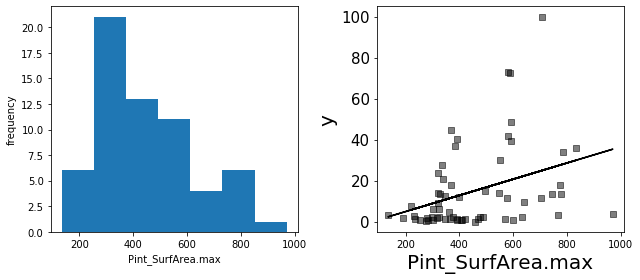

R^2 = 0.12; p-value = 4.83E-03

-------------------------------------------------------------------------------

x176 Pint_SurfArea.delta


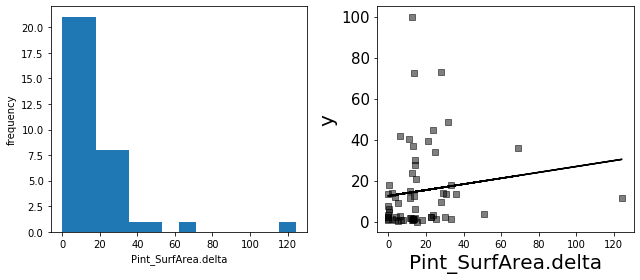

R^2 = 0.02; p-value = 0.29

-------------------------------------------------------------------------------

x177 Pint_SurfArea.vburmin


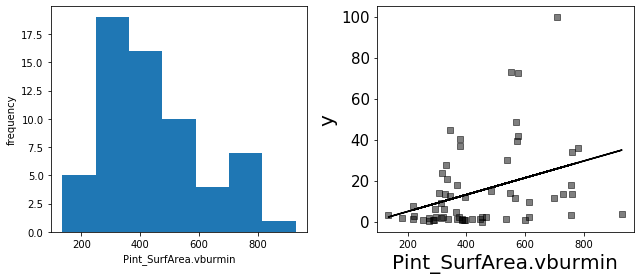

R^2 = 0.13; p-value = 4.72E-03

-------------------------------------------------------------------------------

x178 Pint_Sphericity.Boltz


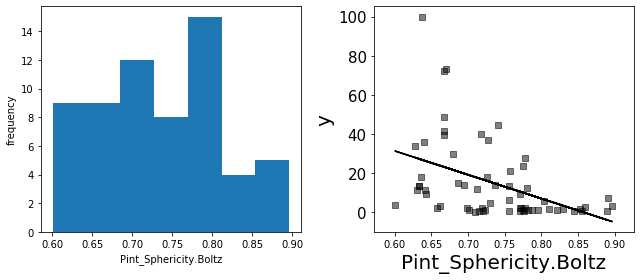

R^2 = 0.20; p-value = 3.10E-04

-------------------------------------------------------------------------------

x179 Pint_Sphericity.min


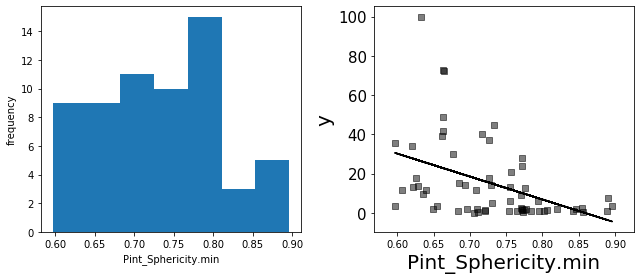

R^2 = 0.19; p-value = 3.61E-04

-------------------------------------------------------------------------------

x180 Pint_Sphericity.max


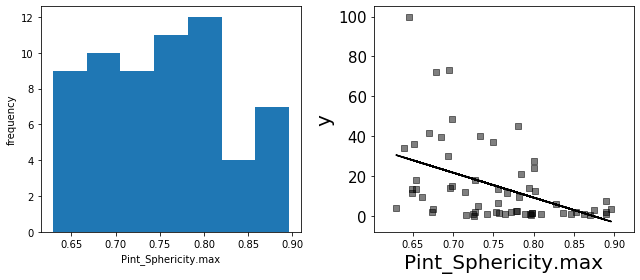

R^2 = 0.20; p-value = 2.56E-04

-------------------------------------------------------------------------------

x181 Pint_Sphericity.delta


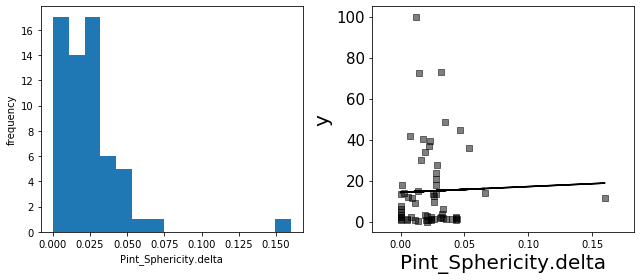

R^2 = 0.00; p-value = 0.80

-------------------------------------------------------------------------------

x182 Pint_Sphericity.vburmin


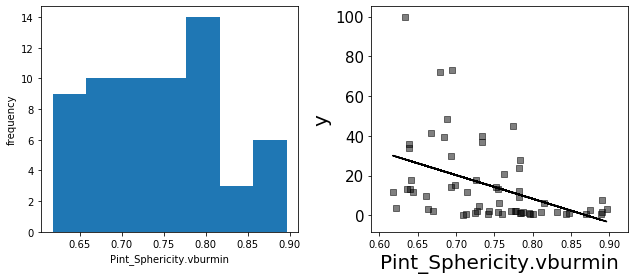

R^2 = 0.19; p-value = 3.87E-04

-------------------------------------------------------------------------------



In [ ]:
# Visualize Histograms and univariate correlations for all (or selected) features
features = range(np.shape(X)[1])   # iterate over all features
# examples for selecting features
#specify names:
# features = [x_names.index("sterimol_5-.5cB5_max")]
#specify x-numbers (1-indexed):
# features_x = ["x74","x133"]
# features = [x_labels.index(i) for i in features_x]
#specify ranges (0-indexed)
# features = itertools.chain(range(75,85),range(90,95))

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind], y)
    fit_line = intercept+slope*X[:,f_ind]
    
    plt.figure(figsize=(9, 4))
    
    plt.subplot(1,2,1)
    plt.hist(X[:,f_ind], bins="auto")
    plt.ylabel("frequency")
    plt.xlabel(X_names[f_ind])
    
    plt.subplot(1,2,2)
    plt.scatter(X[:,f_ind], y,color="black",marker="s",alpha=0.5)    
    plt.plot(X[:,f_ind],fit_line,color="black")
    plt.xlabel(X_names[f_ind],fontsize=20)
    plt.ylabel("y",fontsize=20)

#     plt.xticks(np.arange(round(min(X[:,f_ind])-0.005,3), round(max(X[:,f_ind])+0.005,3), 0.03),fontsize=15)
    plt.yticks(fontsize=15)        
    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")
    
  

## plot a feature vs. another feature

x83 sambvca_pvbur_35.Boltz
x148 visvol_prox_visvol.Boltz

62 samples
R^2 = 0.84; p-value = 1.14E-25


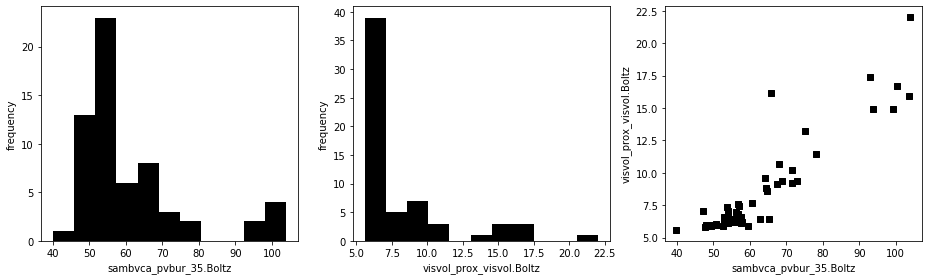

In [ ]:
#select two features to visualize
# can be integer-index of features, or string with x-number
f_ind_1 = "x83"
f_ind_2 = "x148"

if type(f_ind_1) == str:
    [f_ind_1,f_ind_2] = [X_labels.index(i) for i in [f_ind_1,f_ind_2]]

print(X_labels[f_ind_1], X_names[f_ind_1])
print(X_labels[f_ind_2], X_names[f_ind_2])
print("\n{} samples".format(np.shape(X[:,f_ind_1])[0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,f_ind_1],X[:,f_ind_2])
fit_line = intercept+slope*X[:,f_ind_1]
print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

plt.figure(figsize=(13, 4))

plt.subplot(1,3,1)
plt.hist(X[:,f_ind_1], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_1])
plt.subplot(1,3,2)
plt.hist(X[:,f_ind_2], bins="auto",color="black")
plt.ylabel("frequency")
plt.xlabel(X_names[f_ind_2])

plt.subplot(1,3,3)
plt.scatter(X[:,f_ind_1], X[:,f_ind_2],color="black",marker="s")    
#plt.plot(X[:,f_ind_1],fit_line)
plt.xlabel(X_names[f_ind_1])
plt.ylabel(X_names[f_ind_2])
plt.tight_layout()
plt.show()    

## Correlation Map

In [ ]:
%matplotlib notebook
# this will open an interactive plot that you can enlarge and zoom into

corrmap = np.corrcoef(X.T)
plt.matshow(corrmap)
plt.xticks(range(len(X_labels)),X_labels, fontsize=10, rotation=90)
plt.yticks(range(len(X_labels)),X_labels, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

## Single-node Decision Tree

### Regression

Accuracy: 0.44
x124 sterimol_5-.5cB5.min


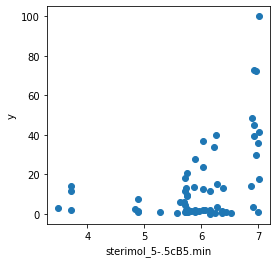

In [ ]:
# import graphviz 

dt = DecisionTreeRegressor(max_depth=1).fit(X, y)
print("Accuracy: {:.2f}".format(dt.score(X, y)))

feat = int(np.where(dt.feature_importances_ != 0)[0])
print(X_labels[feat],X_names[feat])

plt.figure(figsize=(4, 4))
plt.scatter(X[:,feat], y)    
plt.xlabel(X_names[feat])
plt.ylabel("y")

# dot_data = tree.export_graphviz(dt, out_file=None, 
#                      feature_names=X_names,   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph  
plt.show()

### Classify highest and lowest group

x148 visvol_prox_visvol.Boltz
x128 sterimol_B1.Boltz


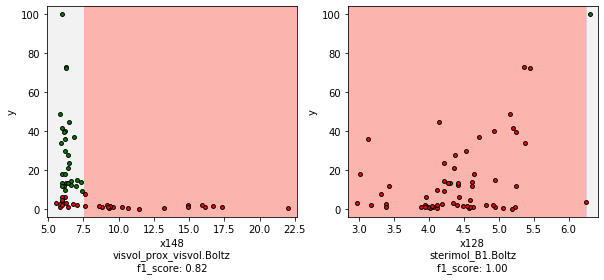

In [ ]:
# find features that separate the group with highest/lowest output y
# change the definition of bins in the histogram to get control over how these groups are defined
y_hist,y_bin_edges = np.histogram(y,bins="auto")
y_class_low = [0 if i < y_bin_edges[1] else 1 for i in y]
y_class_high = [1 if i > y_bin_edges[-2] else 0 for i in y]

plt.figure(figsize=(8.5, 4))
n_classes = 2
plot_colors = "rg"
plot_step = 0.02
y_classes = [np.asarray(y_class_low),np.asarray(y_class_high)]
for y_class,i in zip(y_classes,[1,2]):
    dt = DecisionTreeClassifier(max_depth=1).fit(X, y_class)
    feat = int(np.where(dt.feature_importances_ != 0)[0])    
    a = ("f1_score: {:.2f}".format(metrics.f1_score(y_class,dt.predict(X))))
#    b = ("auc: {:.2f}".format(metrics.roc_auc_score(y_class,dt.predict(X))))
    print(X_labels[feat],X_names[feat])    
    xpltlabel = X_labels[feat] + "\n" + X_names[feat] + "\n" + a# + "\n" + b

    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
    x_min, x_max = X[:, feat].min(), X[:, feat].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.subplot(1,2,i)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)

    plt.xlabel(xpltlabel)
    plt.ylabel("y")

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.tight_layout()

# dot_data = tree.export_graphviz(dt_plt, out_file=None, 
#                      feature_names=[x_names[feat]],   
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph

### Classification

x54 pyr_P.min
Decision threshold = 0.84
Accuracy: 0.90
f1_score: 0.94
N = 62


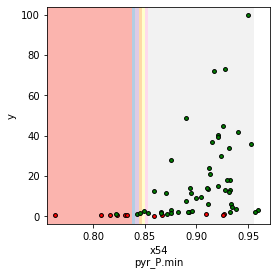

In [ ]:
# divide samples into two classes based on y_cut, find the feature that most clearly distinguishes these groups
y_cut = 1

#this can be done on a subset of features
# features = [i for i in itertools.chain(range(75,85),range(90,95))]
# features = [i for i in range(38,135)]
features = range(np.shape(X)[1])
X_use = X[:,features]

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes=2
dt = DecisionTreeClassifier(max_depth=1).fit(X_use, y_class)

feat = features[int(np.where(dt.feature_importances_ != 0)[0])]
print(X_labels[feat],X_names[feat])

dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,feat].reshape(-1, 1), y_class)
print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt_plt.tree_.threshold[0],
        dt_plt.score(X[:,feat].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt_plt.predict(X[:,feat].reshape(-1, 1))),
        len(y)
    ))

plot_colors = "rg"
plot_step = 0.02
x_min, x_max = X[:,feat].min(), X[:,feat].max()
y_min, y_max = y.min(), y.max()
dx,dy = x_max-x_min,y_max-y_min
xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                     np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))

plt.figure(figsize=(4, 4))    
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
xpltlabel = X_labels[feat] + "\n" + X_names[feat]

plt.xlabel(xpltlabel)
plt.ylabel("y")

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y_class == i)
    plt.scatter(X[idx, feat], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    

plt.show()

### Property threshold

x146 visvol_tot_visvol.delta
Decision threshold = 0.83
Accuracy: 0.56
f1_score: 0.00
N = 62


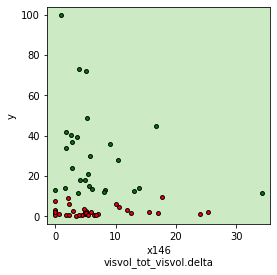

x147 visvol_tot_visvol.vburmin
Decision threshold = 36.47
Accuracy: 0.68
f1_score: 0.55
N = 62


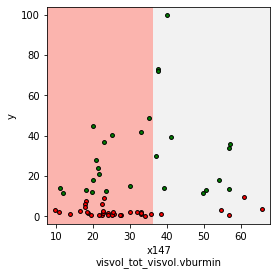

x148 visvol_prox_visvol.Boltz
Decision threshold = 7.38
Accuracy: 0.77
f1_score: 0.79
N = 62


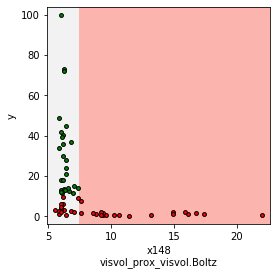

x149 visvol_prox_visvol.min
Decision threshold = 6.26
Accuracy: 0.77
f1_score: 0.79
N = 62


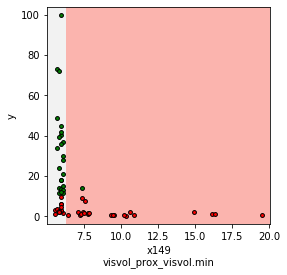

x150 visvol_prox_visvol.max
Decision threshold = 10.98
Accuracy: 0.74
f1_score: 0.76
N = 62


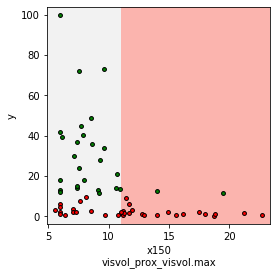

In [ ]:
# divide samples into two classes based on y_cut, visualize how features separate these classes
y_cut = 10

#select features here
# features = range(len(X_labels))   # iterate over all features
features = itertools.chain(range(145,150))

y_class = np.array([0 if i < y_cut else 1 for i in y])
n_classes = 2
plot_colors = "rg"
plot_step = 0.02

for f_ind in features:
    feature = X_labels[f_ind]
    print(feature, X_names[f_ind])
    dt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)   
    print("Decision threshold = {:.2f}\nAccuracy: {:.2f}\nf1_score: {:.2f}\nN = {}".format(
        dt.tree_.threshold[0],
        dt.score(X[:,f_ind].reshape(-1, 1), y_class),
        metrics.f1_score(y_class,dt.predict(X[:,f_ind].reshape(-1, 1))),
        len(y)
    ))
    
    dt_plt = DecisionTreeClassifier(max_depth=1).fit(X[:,f_ind].reshape(-1, 1), y_class)
    x_min, x_max = X[:,f_ind].min(), X[:,f_ind].max()
    y_min, y_max = y.min(), y.max()
    dx,dy = x_max-x_min,y_max-y_min
    xx, yy = np.meshgrid(np.arange(x_min-0.04*dx, x_max+0.04*dx, plot_step),
                         np.arange(y_min-0.04*dy, y_max+0.04*dy, plot_step))
    
    plt.figure(figsize=(4, 4))    
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = dt_plt.predict(xx.ravel().reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap="Pastel1")#plt.cm.RdYlBu)
    xpltlabel = X_labels[f_ind] + "\n" + X_names[f_ind]

    plt.xlabel(xpltlabel)
    plt.ylabel("y")

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_class == i)
        plt.scatter(X[idx, f_ind], y[idx], c=color,cmap=plt.cm.RdYlBu, edgecolor='black', s=15)    
    
    plt.show()

    



# Data preparation: Training/Test set split, Scaling

## Optional preparations

In [ ]:
# perform transformations on y
y_orig = y.copy() # this is a backup of y

# y = np.exp(y_orig)

#log-transformation: either remove all samples with y=0 () or add a small amount to y to avoid log(0).
# y = np.log(y+0.00001)
#or
# y = np.log(y[y.nonzero()[0]])
# y_labels_orig,X_orig = y_labels.copy(),X.copy()
# y_labels = y_labels[y.nonzero()[0]]
# X = X[y.nonzero()[0]]

# y = abs(y)

In [ ]:
# remove samples based on a feature-value
# comment-out first line in Train/test split if using this
select_feature = "x84"

# define cutoff 
mask_prop = X[:,X_labels.index(select_feature)]<55

X_sel,y_sel,y_labels_sel = X[mask_prop],y[mask_prop],y_labels[mask_prop]
print("Shape X: {}".format(X_sel.shape))
print("Shape y: {}".format(y_sel.shape)) 
print("Shape labels: {}".format(y_labels_sel.shape)) 

Shape X: (42, 182)
Shape y: (42,)
Shape labels: (42,)


In [ ]:
# remove samples based on index (0-indexed)
# comment-out first line in Train/test split if using this

exclude = [16,18,19,23,24,25]+[i for i in range(26,37)]
print(exclude)
mask = [i for i in range(len(y)) if i not in exclude]
X_sel,y_sel,y_labels_sel = X[mask],y[mask],y_labels[mask]

## Training/Test set split

TS: [43, 8, 28, 35, 37, 61, 41, 36, 48, 0, 1, 59, 11, 23, 54, 60, 50, 55, 57, 32, 2, 51, 45, 42, 10, 44, 33, 5, 13, 7, 18, 47, 46, 31, 30, 34, 20]
VS: [3, 4, 6, 9, 12, 14, 15, 16, 17, 19, 21, 22, 24, 25, 26, 27, 29, 38, 39, 40, 49, 52, 53, 56, 58]
y_mean TS: 11.754
y_mean VS: 19.558
Shape X_train: (37, 182)
Shape X_test:  (25, 182)


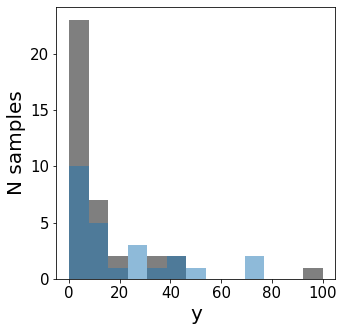

In [ ]:
# comment this line out if preselection was performed
X_sel,y_sel,labels_sel,exclude = X,y,y_labels,[]

# select method of split:
# random
# y_equidist - picks points that evenly span the output variable y. 
#              Normally doesn't pick highest/lowest values but this can be activated by changing the variable no_extrapolation in the respective section
# ks - Kennard Stone algorithm picks points based on an even distribution in feature space
# define - give a list of sample indices for either VS or TS in the corresponding code section 
# none - all samples in TS

# the numbers in the variables VS and TS refer to the original 0-indexed sample numbers 

split = "ks"#random"
test_ratio = 0.4

if split == "random":
    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y_sel, random_state=randomstate+3, test_size=test_ratio)    
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]
    
elif split == "define":
    # numbers according to sample lines in the excel sheet (that is, including indexes of 'excluded' samples)
    # for defining the TS, change the names of TS and VS in the next three lines
    TS = [1,2,3]
    
    #TS = [i-1 for i in VS] # this can be commented out if 0-indexed numbers were defined above
    VS = [i for i in range(X.shape[0]) if i not in VS and i not in exclude]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
elif split == "ks":
    import kennardstonealgorithm as ks
    TS,VS = ks.kennardstonealgorithm(X_sel,int((1-test_ratio)*np.shape(X_sel)[0]))
    X_train, y_train,X_test, y_test = X_sel[TS], y_sel[TS],X_sel[VS], y_sel[VS]
  
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]   

elif split == "y_equidist":
    no_extrapolation = True
    
    import kennardstonealgorithm as ks
    if no_extrapolation:
        minmax = [np.argmin(y_sel),np.argmax(y_sel)]
        y_ks = np.array(([i for i in y_sel if i not in [np.min(y_sel),np.max(y_sel)]]))
        y_ks_indices = [i for i in range(len(y_sel)) if i not in minmax]
        
        # indices relative to y_ks:
        VS_ks,TS_ks = ks.kennardstonealgorithm(y_ks.reshape(np.shape(y_ks)[0],1),int((test_ratio)*(2+np.shape(y_ks)[0])))
        # indices relative to y_sel:
        TS_ = sorted([y_ks_indices[i] for i in list(TS_ks)]+minmax)
        VS_ = sorted([y_ks_indices[i] for i in VS_ks])

    else:
        VS_,TS_ = ks.kennardstonealgorithm(y_sel.reshape(np.shape(y_sel)[0],1),int((test_ratio)*np.shape(y_sel)[0]))
    
    X_train, y_train,X_test, y_test = X_sel[TS_], y_sel[TS_],X_sel[VS_], y_sel[VS_]
    
    # indices relative to y
    TS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_train]
    VS = [np.argwhere(np.all(X==i,axis=1))[0,0] for i in X_test]

elif split == "none":
    TS, VS = [i for i in range(X.shape[0]) if i not in exclude],[]
    X_train, y_train,X_test, y_test = X[TS],y[TS],X[VS],y[VS]
    
else: 
    raise ValueError("split option not recognized")
     

print("TS: {}".format(TS))
print("VS: {}".format(VS))
print("y_mean TS: {:.3f}".format(np.mean(y_train)))
print("y_mean VS: {:.3f}".format(np.mean(y_test)))
print("Shape X_train: {}".format(X_train.shape))
print("Shape X_test:  {}".format(X_test.shape))   
plt.figure(figsize=(5, 5))
hist,bins = np.histogram(y_sel,bins="auto")#"auto"
plt.hist(y_train, bins, alpha=0.5, label='y_train',color="black")
plt.hist(y_test, bins, alpha=0.5, label='y_test')
# plt.legend(loc='best')
plt.xlabel("y",fontsize=20)
plt.ylabel("N samples",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Feature Scaling 

In [ ]:
# scale features by mean/variance, pick the relevant option (normally: StandardScaler)

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_all_sc = scaler.transform(X_all)

## Cross-terms/Interaction terms

In [ ]:
# Add polynomial features/interaction terms
# this is not yet implemented properly in some sections. 
# for 5.1-manual selection: specify cross-term with space between the components: x1 x40 + x6
# Essentially only section 5.2 can use cross-terms so far
# don't run this twice

polyfeats = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
X_train_p = polyfeats.fit_transform(X_train_sc)
X_test_p = polyfeats.transform(X_test_sc)
X_all_p = polyfeats.transform(X_all_sc)

def add_to_x(matchobj):
    if "^" in matchobj.group(0):
        n = int(matchobj.group(0).split("^")[0])+1
        return("{} x{}".format(n,n))
    else:
        return(str(int(matchobj.group(0))+1))
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])



In [ ]:
# filter out non-significant crossterms based on p-value with target variable
p_val_cutoff = 0.005

r2s = []
pvals = []
for f_ind,feature in enumerate(X_train_p.T):
    slope, intercept, r_value, p_value, std_err = stats.linregress(feature, y_train)    
    r2s.append(r_value**2)
    pvals.append(p_value)
    
r2s_ = np.asarray(r2s)
pvals_ = np.asarray(pvals)

keep_p_ = [i[0] for i in np.argwhere(pvals_<p_val_cutoff) if i not in range(np.shape(X_all)[1])]
keep_p = [i for i in range(np.shape(X_all)[1])] + keep_p_

def sub_label_to_name(matchobj):
    return(X_labelname_dict[matchobj.group(0)])
def sub_labelname(matchobj):
    return(matchobj.group(0)+" "+X_labelname_dict[matchobj.group(0)])
    
pfnames = np.asarray([re.sub("[0-9]+(\^[0-9])*",add_to_x,st) for st in polyfeats.get_feature_names()])
X_p_labels = list(np.reshape(pfnames[keep_p],len(keep_p)))
X_p_names = [re.sub("x[0-9]+",sub_label_to_name,st) for st in X_p_labels]
X_p_labelname = [re.sub("x[0-9]+",sub_labelname,st) for st in X_p_labels]

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train_p[:,keep_p])
X_test_sc = scaler.transform(X_test_p[:,keep_p])
X_all_sc = scaler.transform(X_all_p[:,keep_p])

X_labels = X_p_labels
X_names = X_p_names
X_labelname = X_p_labelname

print("{} cross-terms with p-value < {}".format(len(keep_p_),p_val_cutoff))

# Linear modelling, feature selection

## Manual selection of features

Features: x5 + x17 + x54 + x134

Parameters:
   22.0143 + 
   11.2145 * x5 efg_yy(P).Boltz
   -1.3836 * x17 homo_omega.Boltz
    7.1060 * x54 pyr_P.min
   -1.0405 * x134 sterimol_B5.min

Training R2  = 0.257
Training Q2  = -0.151
Training MAE = 13.780
Training K-fold R2 = -0.261 (+/- 0.055)

Test R2      = -0.149
Test MAE     = 17.092


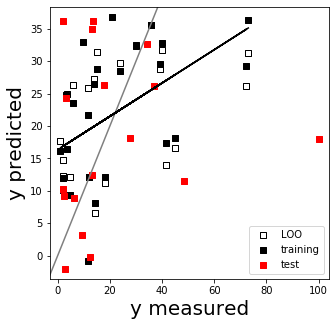

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1.729
Date:                Mon, 27 Jan 2020   Prob (F-statistic):              0.183
Time:                        13:50:41   Log-Likelihood:                -106.75
No. Observations:                  25   AIC:                             223.5
Df Residuals:                      20   BIC:                             229.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.0143      3.870      5.688      0.0

In [ ]:
#provide an x__ model (string, any order of terms)
features_x = "x134 + x5 + x54 + x17" 
features_py = sorted([X_labels.index(i.strip()) for i in features_x.split("+")])

# features_py = []
#features = sorted([int(i[1:]) for i in re.findall("x\d+",features_x)])
#features_py = [i-1 for i in features]


X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
#lr = Ridge(alpha=1E-5).fit(X_train_sel, y_train)
lr = LinearRegression().fit(X_train_sel, y_train)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores = repeated_k_fold(X_train_sel,y_train,k=4,n=200)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores.mean(), kfoldscores.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=True,sav=False,label="y",loo_pred=loo_train)

model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

In [ ]:
# add all individual features to the manual model
add_df = pd.DataFrame(index=X_labelname,columns=["label_sep","label_abs","Training R2","Training Q2"],dtype=float)

update_model = False
for f_ind in range(len(X_labels)):
    features_iter = features_py + [f_ind]    
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    add_df.iloc[f_ind,:] = [X_labels[f_ind],"x"+str(f_ind+1),lr.score(X_train_sel, y_train),q2]

if update_model and X_labelname.index(add_df['Training Q2'].idxmax()) not in features_py:
    features_py.append(X_labelname.index(add_df['Training Q2'].idxmax()))
add_df.sort_values(by=['Training Q2'],ascending=False).head(20)

,label_sep,label_abs,Training R2,Training Q2
x54 pyr_P.min,x54,x54,0.192754,0.080571
x60 pyr_alpha.max,x60,x60,0.197143,0.074607
x163 visvol_ratio_distvis_proxvis.Boltz,x163,x163,0.167124,0.062848
x179 Pint_Sphericity.min,x179,x179,0.156133,0.060353
x180 Pint_Sphericity.max,x180,x180,0.167549,0.058592
x139 sterimol_lval.min,x139,x139,0.142703,0.058063
x182 Pint_Sphericity.vburmin,x182,x182,0.163650,0.056666
x57 pyr_P.vburmin,x57,x57,0.157710,0.056269
x178 Pint_Sphericity.Boltz,x178,x178,0.154506,0.054531
x62 pyr_alpha.vburmin,x62,x62,0.160337,0.052001


In [ ]:
# remove each individual feature from the manual model
print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))

rem_df = pd.DataFrame(index=[X_labelname[i] for i in features_py],
                      columns=["Training R2","Training Q2"])
for f_ind in features_py:
    features_iter = [i for i in features_py if i != f_ind]
#     print(feature, x_names[f_ind])
    X_train_sel = X_train_sc[:,features_iter]
    X_test_sel = X_test_sc[:,features_iter]
    # lr = Ridge(alpha=1E-1).fit(X_train_sel, y_train)
    lr = LinearRegression().fit(X_train_sel, y_train)
    q2,loo_train = loo.q2(X_train_sel,y_train,lr)
    rem_df.loc[X_labelname[f_ind],:] = [lr.score(X_train_sel, y_train),q2]

rem_df.sort_values(by=['Training Q2'],ascending=False)

## Forward stepwise selection based on p-values

Add                             163 with p-value 0.00309859
Add                             102 with p-value 0.0437382
Add                             181 with p-value 0.0467704
Add                             131 with p-value 0.0121507
Add                              70 with p-value 0.0328665
Add                              96 with p-value 0.0387724
Add                              42 with p-value 0.00741455
Add                             134 with p-value 0.0306893
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     10.85
Date:                Thu, 19 Mar 2020   Prob (F-statistic):           8.25e-07
Time:                        10:16:16   Log-Likelihood:                -135.07
No. Observations:                  37   AIC:        

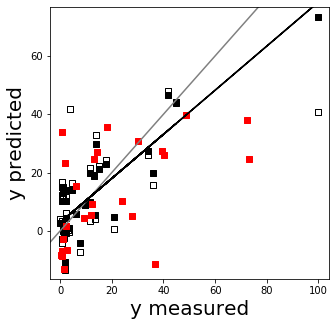

In [ ]:
# Forward stepwise selection based on p-value
# threshold values refer to p-value of individual features
threshold_in = 0.05
threshold_out = 0.075 # must be larger than threshold_in

use_manual_feats = False # if True, model from previous section will be used as starting point

import stepwise_selection2 as step_s
if not use_manual_feats:
    features_py=[]

features_py = step_s.stepwise_selection(pd.DataFrame(X_train_sc), y_train,
                    initial_list=features_py,threshold_in=threshold_in,threshold_out=threshold_out,verbose=True)

print("\n"+" + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\n"+" + ".join([X_labelname[i] for i in sorted(features_py)]))

X_train_sel = X_train_sc[:,features_py]
X_test_sel = X_test_sc[:,features_py]
#lr = Ridge(alpha=1E-6).fit(X_train_sel, y_train)
lr = LinearRegression().fit(X_train_sel, y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100,reg=LinearRegression())

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(features_py)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(features_py)[i]]) for i in range(len(features_py))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)


## other forward feature selection implementations

x54 + x60 + x95 + x164

pyr_P.min + pyr_alpha.max + sambvca_pvbur_Qmin_150.max + visvol_ratio_distvis_proxvis.min
Training R2;Training Q2;Test R2;0.36;-0.22;0.14


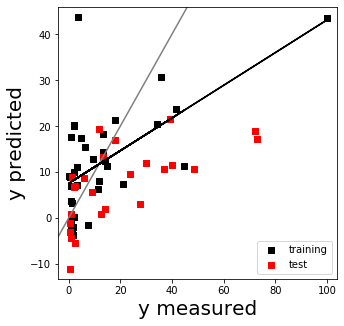

In [ ]:
#Scikit-learn - forward feature selection
# largely useless
# options for criteria: 
# mutual_info_regression, f_regression
# select number of features with k

criteria = f_regression
skb = SelectKBest(criteria,k=4).fit(X_train_sc,y_train)
selected_feats = skb.get_support(indices=True)
print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([X_names[i] for i in sorted(selected_feats)]))

X_train_sel = skb.transform(X_train_sc)
X_test_sel = skb.transform(X_test_sc)
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)

y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

In [ ]:
# Forward stepwise selection based on AIC ("aic") or Q2 ("q2")
criteria = "aic"
#criteria = "q2"

import forwardselect_q5 as fsq

df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))

newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
a,b = fsq.Forward_Select(df,"y","Regression",criteria)
selected_feats = [int(i[1:]) for i in b]
print(" + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\n"+" + ".join([x_names[i] for i in sorted(selected_feats)]))

X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
lr = LinearRegression().fit(X_train_sel, y_train)
q2,loo_train = loo.q2(X_train_sel,y_train)
print("\n\n")
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

plot_fit(y_train,y_pred_train,y_test,y_pred_test)

# uncomment to add model to candidate list
# keepmodels.append(features_py)

Time taken for 6501 iterations (minutes): 5.40
Score = -2051.94, Number Selected = 39
model formula: y ~ x164 + x103 + x182 + x132 + x71 + x97 + x43 + x135 + x11 + x95 + x120 + x163 + x22 + x17 + x49 + x26 + x32 + x52 + x119 + x74 + x83 + x37 + x170 + x153 + x113 + x20 + x141 + x46 + x168 + x158 + x172 + x50 + x140 + x56 + x19 + x79 + x124 + x25 + x157 
Time taken for Final Model (minutes): 5.40
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Thu, 19 Mar 2020   Prob (F-statistic):                nan
Time:                        10:51:32   Log-Likelihood:                 1072.9
No. Observations:                  37   AIC:                            -2072.
Df Residuals:                       0   BIC:    

NameError: name 'x_names' is not defined

## Forward stepwise selection keeping a set of candidates at each step

### Model search

Step 1
Step 2
Finished 1 and 2 parameter models. Time taken (sec): 25.6555
Step 3
cutpar:  1
cutpar:  1
cutpar:  1
Step 4
cutpar:  1
cutpar:  1
cutpar:  1
Step 5
cutpar:  2
cutpar:  2
cutpar:  2
Step 6
cutpar:  2
cutpar:  2
cutpar:  2
Step 7
cutpar:  2
cutpar:  2
cutpar:  2
Step 8
cutpar:  3
cutpar:  3
cutpar:  3
Done. Time taken (minutes): 6.71


Best model:
1 + x116 + x158 + x179 + x29 + x40 + x67
1 + Pint_Sphericity.max + nborbsP_BD-S*(P-C)_min_E.Boltz + nborbsP_BD-S*(P-C)_avg_Occ.Boltz + nborbsP_LP(P)_Occ.Boltz + sambvca_pvbur_Qmax_150.Boltz + pyr_P.vburmin + qpole_xx.max

Features: x29 + x40 + x67 + x116 + x158 + x179

Parameters:
   11.7543 + 
  -15.7079 * x29 nborbsP_LP(P)_Occ.Boltz
    6.6109 * x40 sambvca_pvbur_Qmax_150.Boltz
  -40.0428 * x67 qpole_ampl.vburmin
    9.0511 * x116 sambvca_pvbur_vprox/vdist.delta
  -29.7725 * x158 visvol_ratio_vis_tot.Boltz
   -5.7375 * x179 Pint_Sphericity.min

Training R2  = 0.663
Training Q2  = 0.457
Training MAE = 6.885
Training K-fold R2 = 0

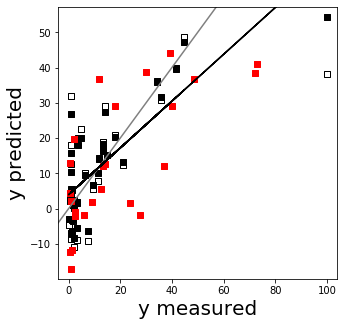

In [ ]:
# Forward stepwise selection keeping a set of candidates at each step
n_steps = 8
n_candidates = 10
collin_criteria = 0.5 # this is R2
skipfeatures = [] #["x4","x3"]

import ForwardStepCandidates_2 as fsc
df = pd.DataFrame(np.hstack((X_train_sc,y_train[:,None])))
newcols = ["x"+str(i+1) for i in df.columns.values]
df.columns = newcols
response = newcols[-1]
df.rename(columns={response:"y"},inplace=True)
df.drop(skipfeatures,axis=1,inplace=True)

results,models,scores,sortedmodels,candidates = fsc.ForwardStep_py(df,'y',
                    n_steps=n_steps,n_candidates=n_candidates,collin_criteria=collin_criteria)
model_sel = results.loc[0,"Model"]
selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print("\n\nBest model:")
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[candidates[0]].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)

### View models as list

In [ ]:
# view best models
results.sort_values(by=['Q^2'],ascending=False).head(25)

,Model,n_terms,R^2,Q^2
0,"(x116, x158, x179, x29, x40, x67)",6,0.663138,0.457043
1,"(x116, x158, x179, x29, x40, x82)",6,0.660975,0.449209
2,"(x116, x158, x179, x29, x40, x69)",6,0.663541,0.449085
3,"(x116, x150, x158, x179, x29, x40, x67)",7,0.663154,0.446294
4,"(x116, x158, x179, x29, x40, x78)",6,0.650816,0.444886
5,"(x10, x127, x150, x179, x4, x40, x70)",7,0.666933,0.440762
6,"(x116, x158, x179, x29, x40, x64)",6,0.648778,0.440564
7,"(x116, x150, x158, x179, x29, x40, x82)",7,0.660975,0.438718
8,"(x116, x159, x179, x29, x40, x67)",6,0.667932,0.438518
9,"(x116, x158, x179, x29, x40, x66, x67)",7,0.671348,0.436722


### Filter results

In [ ]:
# view models with a specific number of terms
selmods = results[results.n_terms <=2].sort_values(by=['Q^2'],ascending=False)
selmods.head(25)

NameError: name 'results' is not defined

In [ ]:
# example for filtering results
selmods2 = results.loc[[i for i in results.index if "x113" in results.loc[i,"Model"] and "x49" not in results.loc[i,"Model"]]][results.n_terms < 5].sort_values(by=['Q^2'],ascending=False)
selmods2

In [ ]:
# filter models that contain more than one term that is also in a reference model
reference_model = 0 # this number refer to the index in 'results' or 'selmods', whichever is used 
use_df = results # or: selmods

uniquemods = {use_df.loc[reference_model,"Model"]:reference_model}
for ind in use_df.index:
    selmod = use_df.loc[ind,"Model"]
    if len(selmod) <= 2:
        continue
        
    add = True
    for mod in uniquemods.keys():
        if len([i for i in mod if i in selmod]) >= 2:
            add = False
            break
    if add:      
        uniquemods[use_df.loc[ind,"Model"]] = ind
    
    
print(len(uniquemods.keys()))
selmods2 = results.loc[uniquemods.values()]
selmods2

### Visualize models

In [ ]:
# visualize other models
model_sel = results.loc[1,"Model"]

#other ways of selecting models:
# model_sel = results.iloc[selmods.index[3],0]
# model_sel = results.iloc[785,0]
# model_sel = ("x100","x31")


selected_feats = [X_labels.index(i) for i in models[model_sel].terms]
X_train_sel = X_train_sc[:,selected_feats]
X_test_sel = X_test_sc[:,selected_feats]
print(models[model_sel].formula)
print("1 + "+" + ".join([X_names[X_labels.index(i)] for i in models[model_sel].terms])+"\n")
lr = LinearRegression().fit(X_train_sel,y_train)
y_pred_train = lr.predict(X_train_sel)
y_pred_test =  lr.predict(X_test_sel)

q2,loo_train = loo.q2(X_train_sel,y_train)
kfoldscores_self = repeated_k_fold(X_train_sel,y_train,k=5,n=100)

print("Features: " + " + ".join(["x"+str(i+1) for i in sorted(selected_feats)]))
print("\nParameters:\n{:10.4f} + \n".format(lr.intercept_) + "\n".join(["{:10.4f} * {}".format(lr.coef_[i],X_labelname[sorted(selected_feats)[i]]) for i in range(len(selected_feats))]))

print(f"\nTraining R2  = {lr.score(X_train_sel, y_train):.3f}\nTraining Q2  = {q2:.3f}")
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_pred_train):.3f}")

print("Training K-fold R2 = {:.3f} (+/- {:.3f})".format(kfoldscores_self.mean(), kfoldscores_self.std() ** 2))
print(f"\nTest R2      = {r2_val(y_test,y_pred_test,y_train):.3f}\nTest MAE     = {metrics.mean_absolute_error(y_test,y_pred_test):.3f}")

plot_fit(y_train,y_pred_train,y_test,y_pred_test,leg=False,sav=False,label="y",loo_pred=loo_train)
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train_sel))).fit()
print(model.summary())

## Ridge Regression, no feature selection

In [ ]:
linm = Ridge().fit(X_train_sc, y_train)

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,4,9)
for parm in parm_range:
    print(parm)
    linm = Ridge(alpha=parm).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,Ridge(alpha=parm))
    
    y_pred_train = linm.predict(X_train_sc)
    y_pred_test =  linm.predict(X_test_sc)
    #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(linm.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
        
    r2s.append(linm.score(X_train_sc, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
linm = Ridge(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = linm.predict(X_train_sc)
y_pred_test =  linm.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

NameError: name 'X_train_sc' is not defined

## Lasso feature selection

In [ ]:
# Lasso feature selection

r2s = []
q2s = []
parms = []
parm_range = np.logspace(-4,1,6)
for parm in parm_range:
    print(parm)
    lasso = Lasso(alpha=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(lasso.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(lasso.coef_!=0)[0]]
    try:
        q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
        lr = LinearRegression().fit(X_train_sel,y_train)
        y_pred_train = lr.predict(X_train_sel)
        y_pred_test =  lr.predict(X_test_sel)
        #print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,metrics.r2_score(y_pred_test,y_test)))
        print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lr.score(X_train_sel, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
        #print(lr.score(X_train_sel,y_train),lr.score(X_test_sel,y_test))
    except:
        pass
    print("     Number of features used: {}".format(np.sum(lasso.coef_ != 0)))
    # print(np.where(lr.coef_ != 0)[1])
    
    r2s.append(lasso.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)

bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
lasso = Lasso(alpha=bestparm).fit(X_train_sc, y_train)
y_pred_train = lasso.predict(X_train_sc)
y_pred_test =  lasso.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    
    
# llbic = LassoLarsIC(criterion="bic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llbic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llbic.coef_!=0)[0]]
# print("\n\nLassoLarsIC bic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llbic.score(X_train_sc, y_train),q2,llbic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llbic.coef_ != 0)))

# llaic = LassoLarsIC(criterion="aic").fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(llaic.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(llaic.coef_!=0)[0]]
# print("\n\nLassoLarsIC aic")
# try:
#     q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
#     print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llaic.score(X_train_sc, y_train),q2,llaic.score(X_test_sc, y_test)))
# except:
#     pass
# print("Number of features used: {}".format(np.sum(llaic.coef_ != 0)))

# lassocv = LassoCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(lassocv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(lassocv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nLassoCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(lassocv.score(X_train_sc, y_train),q2,lassocv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(lassocv.coef_ != 0)))
# print(np.where(lassocv.coef_ != 0)[1])

llcv = LassoLarsCV(cv=LeaveOneOut()).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(llcv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(llcv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
print("\n\nLassoLarsCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(llcv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(llcv.coef_ != 0)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = llcv.predict(X_train_sc)
y_pred_test =  llcv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)    



## Elastic Net

In [ ]:
%%time
encv = ElasticNetCV(l1_ratio=[.01,.05,.66,.1,.2,.3, .5, .7, .9, .95, .99, 1],
#                     n_alphas=500,
                    alphas=np.logspace(-1,4,100),
                    cv=3,n_jobs=-1,max_iter=1000000).fit(X_train_sc, y_train)
X_train_sel = X_train_sc[:,np.where(encv.coef_!=0)[0]]
X_test_sel = X_test_sc[:,np.where(encv.coef_!=0)[0]]
q2,loo_train = loo.q2(X_train_sel,y_train,Ridge(alpha=encv.alpha_))
print("\n\nElasticNetCV")
print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(encv.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
print("Number of features used: {}".format(np.sum(encv.coef_ != 0)))
print("Best hyperparameters: l1_ratio = {}, alpha = {}".format(encv.l1_ratio_,encv.alpha_))

y_pred_train = encv.predict(X_train_sc)
y_pred_test =  encv.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test) 


## Orthogonal Matching Pursuit

In [ ]:
# Orthogonal Matching Pursuit

parm_range = range(1,10)
print(np.shape(X_train_sc))
print(np.shape(y_train))
for parm in parm_range:
    print(parm)
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=parm).fit(X_train_sc, y_train)
    X_train_sel = X_train_sc[:,np.where(omp.coef_!=0)[0]]
    X_test_sel = X_test_sc[:,np.where(omp.coef_!=0)[0]]
    q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(omp.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

    print("     "+" + ".join(["x"+str(i+1) for i in np.where(omp.coef_ != 0)[0]]))
    #print("     Number of features used: {}".format(np.sum(lr.coef_ != 0)))
    

# ompcv = OrthogonalMatchingPursuitCV(cv=LeaveOneOut(),n_jobs=-1).fit(X_train_sc, y_train)
# X_train_sel = X_train_sc[:,np.where(ompcv.coef_!=0)[0]]
# X_test_sel = X_test_sc[:,np.where(ompcv.coef_!=0)[0]]
# q2,loo_train = loo.q2(X_train_sel,y_train,LinearRegression())
# print("\n\nOrthogonalMatchingPursuitCV")
# print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(ompcv.score(X_train_sc, y_train),q2,ompcv.score(X_test_sc, y_test)))
# print("Number of features used: {}".format(np.sum(ompcv.coef_ != 0)))

# print("\n"+" + ".join(["x"+str(i+1) for i in np.where(ompcv.coef_!=0)[0]]))
# print("\n"+" + ".join([X_names[i] for i in np.where(ompcv.coef_!=0)[0]]))

# y_pred_train = ompcv.predict(X_train_sc)
# y_pred_test =  ompcv.predict(X_test_sc)
# plot_fit(y_train,y_pred_train,y_test,y_pred_test)


# Nonlinear Modelling

## Kernel Ridge Regression 

In [ ]:
# Kernel Ridge Regression 
# kernel options: linear, poly, rbf

r2s = []
q2s = []
parms = []
print("\n\nKernelRidge")

kernel="poly"
degree=2

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print(parm)
    kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=parm
    ).fit(X_train_sc, y_train)
    q2,loo_train = loo.q2(X_train_sc,y_train,KernelRidge(kernel=kernel,degree=degree,alpha=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        kr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(kr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
kr = KernelRidge(
        kernel=kernel,
        degree=degree,
        alpha=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = kr.predict(X_train_sc)
y_pred_test =  kr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)



## Support Vector Regression

In [ ]:
# SVR

r2s = []
q2s = []
parms = []
print("\n\nSupport Vector Regression")

kernel="poly"
degree=2
gamma="auto"

parm_range = np.logspace(-3,3,15)
for parm in parm_range:
    print("{:.2E}".format(parm))
    svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=parm
    ).fit(X_train_sc, y_train)
    
    q2,loo_train = loo.q2(X_train_sc,y_train,SVR(kernel=kernel,degree=degree,gamma=gamma,C=parm))
    print("     Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        svr.score(X_train_sc, y_train),q2,r2_val(y_test,y_pred_test,y_train)))
    r2s.append(svr.score(X_train, y_train))
    q2s.append(q2)
    parms.append(parm)
    
bestparm = parms[np.argmax(q2s)]
print("\n\nUsing hyperparameter = {}".format(bestparm))
svr = SVR(
        kernel=kernel,
        degree=degree,
        gamma=gamma,
        C=bestparm
    ).fit(X_train_sc, y_train)
y_pred_train = svr.predict(X_train_sc)
y_pred_test =  svr.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)
   

# keepmodels_[svr] = ()

## Regression with Principal Components

In [ ]:
# Regression with Principal Components

for npca in range(1,9):
    pca = PCA(n_components=npca)
    pca.fit(scaler.transform(X_sel))
#     pca.fit(X_train_sc)
    X_train_pca = pca.transform(X_train_sc)
    X_test_pca = pca.transform(X_test_sc)

    pca_score = pca.explained_variance_ratio_
    pca_values = pca.singular_values_
    V = pca.components_

    linr = LinearRegression().fit(X_train_pca, y_train)
#     linr = Ridge(alpha=1).fit(X_train_pca,y_train)
    q2,loo_train = loo.q2(X_train_pca,y_train,LinearRegression())
    print("\n\nPC Regression {}".format(npca))
    print("Training R2;Training Q2;Test R2;{:.2f};{:.2f};{:.2f}".format(
        linr.score(X_train_pca, y_train),q2,r2_val(y_test,y_pred_test,y_train)))

    y_pred_train = linr.predict(X_train_pca)
    y_pred_test =  linr.predict(X_test_pca)

    plot_fit(y_train,y_pred_train,y_test,y_pred_test)

    
# # virtual screening
# X_screen_sel = pca.transform(X_all_sc)
# y_pred_vscreen = linr.predict(X_screen_sel)
# y_vscreen["PCA5"] = y_pred_vscreen


# keepmodels_[PCA(n_components=2).fit(scaler.transform(X_sel))] = ("n_components=2")

## Random Forest

Training R2;Test R2;0.85;-2.34


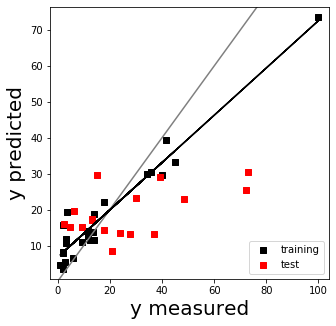

Wall time: 1.03 s


In [ ]:
%%time
# Random forest regression

rf  = RandomForestRegressor(n_estimators=500,random_state=42,n_jobs=None,max_features=None,max_depth=None).fit(
    X_train_sc, y_train)
# rf = GradientBoostingRegressor(
#     n_estimators=50,
#     subsample=.6,
#     max_depth=2,
#     random_state=42,
#     max_features=None,
#     alpha=0.9,
#     ).fit(X_train_sc, y_train)

print("Training R2;Test R2;{:.2f};{:.2f}".format(
    rf.score(X_train_sc, y_train),r2_val(y_test,y_pred_test,y_train)))
# print(np.where(llcv.coef_ != 0)[1])
y_pred_train = rf.predict(X_train_sc)
y_pred_test =  rf.predict(X_test_sc)
plot_fit(y_train,y_pred_train,y_test,y_pred_test)   

# keepmodels_[rf] = ()